In [1]:
import os
import json
import time
import math 
import pandas as pd
import numpy as np
import pickle
import itertools
from datetime import datetime, timezone
from scipy.signal import argrelextrema, medfilt, find_peaks_cwt, find_peaks
from scipy.optimize import curve_fit

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cycler, patches
#from matplotlib.colors import LogNorm

import lgdo.lh5_store as lh5
sto = lh5.LH5Store()

from legendmeta import LegendMetadata
meta_path = '/lfs/l1/legend/users/bianca/sw/legend-metadata'
lmeta = LegendMetadata(path=meta_path)

import pygama.math.peak_fitting as pgf
import pygama.math.histogram as pgh
import pygama.pargen.cuts as pcut

import calibration as cal
import AoE_cal_new as aoe_cal
#import analysis_utility as au

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
def pulser_tag(timestamp, t_pulser, gap = 0.01):
    pulser_idx = []
    for t in t_pulser:
        idx = np.where(np.abs(timestamp-t)<gap)[0]
        if len(idx)>0: pulser_idx.append(idx)
    pulser_idx = np.concatenate(pulser_idx)
    return np.array([False if i in pulser_idx else True for i in range(len(timestamp))])

In [55]:
def get_first_last_peaks(energySeries, detector_type, pulser = True, plot=False):
    """                                                                                                  
    find the most prominent peaks in a spectrum by looking for spikes in derivative of spectrum          
    energySeries: array of measured energies                                                             
    max_num_peaks = maximum number of most prominent peaks to find                                       
    return a histogram around the most prominent peak in a spectrum of a given percentage of width       
    """
    xlo = np.percentile(energySeries, 5)
    xhi = np.percentile(energySeries, 100)
    nb = 3000#int((xhi-xlo)/xpb)
    
    hist, bin_edges = np.histogram(energySeries, bins=np.linspace(xlo,xhi,nb))
    bin_centers = pgh.get_bin_centers(bin_edges)
    if pulser:
        xp = bin_centers[np.where(hist > hist.max()*0.01)][-1]
        hist = hist[np.where(bin_centers < xp-500)]
        bin_centers = bin_centers[np.where(bin_centers < xp-500)]

    peak_idxs, _ = find_peaks(hist,height=hist.max()/30,distance=50)
    peak_energies = bin_centers[peak_idxs]

    peak_max = bin_centers[np.argmax(hist)]
    peak_last = peak_energies[-1]
    print('peak_max', peak_max)
    print(peak_last)
    if (detector_type=="PPC" and peak_max > 1500):   
        #pp = peak_idxs[peak_energies < 1500]
        hh = hist[np.where(bin_centers < 1500)]
        peak_max = bin_centers[np.argmax(hh)]
    if peak_last == peak_max:
        hh = hist[np.where(bin_centers < peak_last-13500)]
        bb = bin_centers[np.where(bin_centers < peak_last-13500)]
        peak_max = bb[np.argmax(hh)]
        if peak_max < 1000:
            hh = hist[np.where((bin_centers>1500) & (bin_centers < 1700))]
            bb = bin_centers[np.where((bin_centers>1500) & (bin_centers < 1700))]
            peak_max = bb[np.argmax(hh)]
    elif detector_type=="ICPC" and peak_max < 1000:   
        hh = hist[np.where((bin_centers>1500) & (bin_centers < 1700))]
        bb = bin_centers[np.where((bin_centers>1500) & (bin_centers < 1700))]
        peak_max = bb[np.argmax(hh)]
    elif detector_type!="PPC" and peak_last <= peak_max + 2000:
        hh = hist[np.where(bin_centers > peak_max + 2000)]
        bb = bin_centers[np.where(bin_centers > peak_max + 2000)]
        peak_max = bb[np.argmax(hh)]
    print('peak_max', peak_max)  
    if plot:
        plt.figure(figsize=(12, 6.75), facecolor='white')
        plt.plot(bin_centers, hist, ds='steps', lw=1, c='b')
        #for e in peak_energies:
        #    plt.axvline(e, color="r", lw=1, alpha=0.6)
        plt.axvline(peak_max, color='r', lw=1, alpha=0.6,label='max peak')
        plt.axvline(peak_last, color='g', lw=1, alpha=0.6,label='last peak')
        plt.xlabel("Energy [uncal]", ha='right', x=1)
        plt.ylabel("Filtered Spectrum", ha='right', y=1)
        plt.yscale('log')
        plt.legend()
    return peak_max, peak_last

In [4]:
def en_calibration(energies, detector_type, guess):
    glines=[510.77, 583.191 ,727, 763, 785, 860.564, 1592, 2103.5, 2614.533]
    try:
        res = cal.calibrate_th228(energies,detector_type, plot=False)
        energies_cal = res['calibration_curve']['m'] * energies + res['calibration_curve']['q']
    except RuntimeError:
        hist, bin_edges = np.histogram(energies, np.linspace(0,20000,500))
        max_thr = 20
        start_search = np.where(hist>max_thr)[0][-1]-30
        bin_centr = (bin_edges[:-1] + bin_edges[1:]) / 2.
        peak = bin_centr[hist[start_search:].argmax()+start_search]
        energies_cal=energies*2614.5/peak

    return energies_cal

In [5]:
def savefig(figure, detector_name, title):
    path= f'/lfs/l1/legend/users/bianca/PSD_HVscan/plots/{detector_name}/'
    os.makedirs(path, exist_ok=True) 
    figure.savefig(f'{path}/{title}_{detector_name}_HVscan.png',dpi=200, bbox_inches='tight')
    

In [181]:
import pygama.math.histogram as pgh
import pygama.math.peak_fitting as pgf
import pygama.pargen.energy_cal as pgc
from scipy import stats

def find_pulser_properties(detector, daqenergy, times, energy="daqenergy"):
    if detector == "V05266A": max_up=2
    elif detector == "V05268A": max_up=45
    elif detector == "V05266B": max_up=10
    elif detector == "V05612A": max_up=2
    elif detector == "V05267A": max_up=20
    elif detector == "V05268B": max_up=2
    elif detector == "V05612B": max_up=10
    else: max_up=45

    if np.nanmax(daqenergy) > 8000:
        hist, bins, var = pgh.get_hist(
            daqenergy, dx=1, range=(1000, np.nanmax(daqenergy))
        )
        allowed_err = 200
    else:
        hist, bins, var = pgh.get_hist(
            daqenergy, dx=0.2, range=(500, np.nanmax(daqenergy))
        )
        allowed_err = 50
    if np.any(var == 0):
        var[np.where(var == 0)] = 1
    imaxes = pgc.get_i_local_maxima(hist / np.sqrt(var), 3)
    peak_energies = pgh.get_bin_centers(bins)[imaxes]
    pt_pars, pt_covs = pgc.hpge_fit_E_peak_tops(
        hist, bins, var, peak_energies, n_to_fit=10
    )
    peak_e_err = pt_pars[:, 1] * 4

    allowed_mask = np.ones(len(peak_energies), dtype=bool)
    for i, e in enumerate(peak_energies[1:-1]):
        i += 1
        if peak_e_err[i] > allowed_err:
            continue
        if i == 1:
            if (
                e - peak_e_err[i] < peak_energies[i - 1] + peak_e_err[i - 1]
                and peak_e_err[i - 1] < allowed_err
            ):
                overlap = (
                    peak_energies[i - 1]
                    + peak_e_err[i - 1]
                    - (peak_energies[i] - peak_e_err[i])
                )
                peak_e_err[i] -= overlap * (
                    peak_e_err[i] / (peak_e_err[i] + peak_e_err[i - 1])
                )
                peak_e_err[i - 1] -= overlap * (
                    peak_e_err[i - 1] / (peak_e_err[i] + peak_e_err[i - 1])
                )

        if (
            e + peak_e_err[i] > peak_energies[i + 1] - peak_e_err[i + 1]
            and peak_e_err[i + 1] < allowed_err
        ):
            overlap = (e + peak_e_err[i]) - (peak_energies[i + 1] - peak_e_err[i + 1])
            total = peak_e_err[i] + peak_e_err[i + 1]
            peak_e_err[i] -= (overlap) * (peak_e_err[i] / total)
            peak_e_err[i + 1] -= (overlap) * (peak_e_err[i + 1] / total)

    out_pulsers = []

    for i, e in enumerate(peak_energies[allowed_mask]):
        if peak_e_err[i] > allowed_err:
            continue
        try:
            daqenergy_arr = np.array(daqenergy)
            times_arr = np.array(times)
            e_cut = (daqenergy_arr > e - peak_e_err[i]) & (daqenergy_arr < e + peak_e_err[i])
            #df_peak = df[e_cut]

            time_since_last = (
                times_arr[e_cut][1:] - times_arr[e_cut][:-1]
            )
            #hist, _ , _ =pgh.get_hist(time_since_last)
            #plt.plot(hist)

            tsl = time_since_last[
                (time_since_last >= 0)
                & (time_since_last < np.percentile(time_since_last, 99.9))
            ]
            bins = np.arange(0.1, 5, 0.001)
            bcs = pgh.get_bin_centers(bins)
            hist, bins, var = pgh.get_hist(tsl, bins=bins)
            maxs = pgc.get_i_local_maxima(hist, max_up) #2) #45)
            maxs = maxs[maxs > 20]

            super_max = pgc.get_i_local_maxima(hist, 500)
            super_max = super_max[super_max > 20]
            if len(maxs) < 2:
                continue
            else:
                max_locs = np.array([0.0])
                max_locs = np.append(max_locs, bcs[np.array(maxs)])
                if (
                    len(np.where(np.abs(np.diff(np.diff(max_locs))) <= 0.001)[0]) > 1
                    or (np.abs(np.diff(np.diff(max_locs))) <= 0.001).all()
                    or len(super_max) > 0
                ):
                    pulser_e = e
                    period = stats.mode(tsl).mode[0]
                    if period > 0.1:
                        out_pulsers.append((pulser_e, peak_e_err[i], period, 'daqenergy'))

                else:
                    continue
        except:
            continue
    return out_pulsers

In [7]:
def find_pulser(daqenergy, pulser_props):
    if len(pulser_props) > 0:
        daqenergy_arr = np.array(daqenergy)
        final_mask = None
        for entry in pulser_props:
            e_cut = (daqenergy_arr < entry[0] + entry[1]) & (
                daqenergy_arr > entry[0] - entry[1]
            )
            if final_mask is None:
                final_mask = e_cut
            else:
                final_mask = final_mask | e_cut
        ids = final_mask
        print(f"pulser found: {pulser_props}")
    else:
        print("no_pulser!!!!!!")
        ids = np.zeros(len(daqenergy_arr), dtype=bool)
    return ids 

### Plotting

In [8]:
IPython_default = plt.rcParams.copy()
SMALL_SIZE = 12
MEDIUM_SIZE = 14
LARGE_SIZE = 16

plt.rc('font', size=SMALL_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)  # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
plt.rcParams["font.family"] = "serif"

matplotlib.rcParams['mathtext.fontset'] = 'stix'

marker_size = 2
line_width = 0.5
cap_size = 0.5
cap_thick = 0.5

colors = cycler('color', ['tab:blue', 'orange', 'g', 'r', 'm', 'y', 'k', 'c', '#8c564b'])
plt.rc('axes', facecolor='white', edgecolor='black',
       axisbelow=True, grid=False, prop_cycle=colors)

### Settings

In [23]:
period = 'p07'
run = 'r009'
nint = 20 #[30, 33, 27, 28, 28, 30, 30, 28, 28, 32] #how many files for each scan
nscan = 10 #how many scans
save_fig = True

### Load files

In [10]:
file_dict = 'l200-p07-r009-hv_scan.json'

In [11]:
raw_dir = f'/lfs/l1/legend/users/dandrea/test_data/raw/tst/{period}-{run}'
dsp_dir = f'/lfs/l1/legend/users/dandrea/test_data/dsp/tst/{period}-{run}'
#par_dsp = '/data1/users/marshall/prod-ref/voltage_scan/inputs/dataprod/overrides/dsp/cal/p03/r000/L200-p03-r000-cal-T%-par_dsp-overwrite.json'

In [12]:
with open(file_dict, "r") as file:
    test_dict = json.load(file)

#with open(par_dsp, "r") as file:
#    par_dsp = json.load(file)

### Take all detectors and operating voltages

In [13]:
key_list_file = open(f'l200-{period}-{run}-tst-key.list', "r")
key_list = key_list_file.read().split('\n')
time_string = key_list[0]
chmap = lmeta.hardware.configuration.channelmaps.on(time_string)
dets_map = lmeta.hardware.detectors.germanium.diodes

In [14]:
with open(file_dict, "r") as file:
    test_dict = json.load(file)

ge_keys = [ge_key for ge_key in test_dict.keys() if (ge_key != 'times')]
operating = [test_dict[ge_key]['operating'] for ge_key in ge_keys]

ge_keys = [ge_key for ge_key,op in zip(ge_keys,operating) if (op != 'Discon.') & (op != '100')]
operating_all = [op for op in operating if (op != 'Discon.') & (op != '100')]
depletion_all = [test_dict[ge_key]['depletion'] for ge_key in ge_keys]
reccomended_all = [test_dict[ge_key]['reccomended'] for ge_key in ge_keys]
dets_map = lmeta.hardware.detectors.germanium.diodes
try:
    manufacturer_hv = True
    depletion_all = [test_dict[ge_key]['depletion'] for ge_key in ge_keys]
    reccomended_all = [test_dict[ge_key]['reccomended'] for ge_key in ge_keys]
except:
    manufacturer_hv = False
    pass

### Files for each scan

In [24]:
dsp_list = []
time_idxs = []
start_times = test_dict['times'][:nscan+1]
for start_time in start_times:
    time_idxs.append([i for i, key in enumerate(key_list) if key == start_time][0])
print(time_idxs)
for ii in range(nscan):
    if (ii+1) == nscan:
        if nscan < 3: ss, ff = time_idxs[ii], nscan+1
        else: ss, ff = time_idxs[ii], -1
    else:
        ss, ff = time_idxs[ii], time_idxs[ii+1]
    print(ii+1, key_list[ss],'->', key_list[ff-1])
    dsp_list_scan = []
    for key in key_list[ss:ff]:
        dsp_list_scan.append(f'{dsp_dir}/l200-{period}-{run}-tst-{key}-tier_dsp.lh5')

    dsp_list.append(dsp_list_scan)

[0, 30, 64, 92, 121, 150, 180, 211, 240, 269]
1 20230929T012259Z -> 20230929T032559Z
2 20230929T033950Z -> 20230929T055716Z
3 20230929T061200Z -> 20230929T082116Z
4 20230929T083846Z -> 20230929T104545Z
5 20230929T215606Z -> 20230930T010754Z
6 20230930T011947Z -> 20230930T033228Z
7 20230930T112330Z -> 20230930T132943Z
8 20230930T134330Z -> 20230930T155505Z
9 20230930T160726Z -> 20230930T181820Z
10 20230930T183226Z -> 20230930T204311Z


### Only PPCs

In [15]:
detectors = [ge_key for ge_key in ge_keys if ge_key.startswith('V05')]
print(detectors)
#no scans for P00537A, P00538B, P00661A

[]


In [16]:
detectors = ['P00574B']
n_volt = ge_keys.index(detectors[0])
n_det = 0

ValueError: 'P00574B' is not in list

### Only Batch 5

In [15]:
detectors = [ge_key for ge_key in ge_keys if ge_key.startswith('V05')]
print(detectors)

['V05261B', 'V05266A', 'V05266B', 'V05268B', 'V05612A', 'V05267B', 'V05261A', 'V05268A', 'V05267A', 'V05612B']


In [177]:
detectors = ['V05612B']
n_volt = ge_keys.index('V05612B')
n_det = 0
#channel = ['ch1104003']

## Loading parameters for each detector and each scan

In [87]:
channel =[]
channel.append('ch1104003') #'ch1116801')
chmap.map("daq.rawid")[int(channel[0][2:])]["name"]

'V05266A'

In [ ]:
from lgdo import show
show("/lfs/l1/legend/users/dandrea/test_data/dsp/tst/p07-r009/l200-p07-r009-tst-20230929T012259Z-tier_dsp.lh5","ch1116801")

V05612B
scan 0
pulser found: [(10131.5, 24.933921993915618, 2.0, 'daqenergy')]
peak_max 1603.7045268420975
17557.343984252177
peak_max 1603.7045268420975

period 1 HV 3700.0 time 7544.881747 s
n.events 479331
scan 1
pulser found: [(10133.5, 23.90952412172667, 2.0, 'daqenergy')]
peak_max 1602.8808374382647
17550.656539833042
peak_max 1602.8808374382647

period 2 HV 3500.0 time 8440.210933 s
n.events 524818
scan 2
pulser found: [(10130.5, 26.598761201981656, 2.0, 'daqenergy')]
peak_max 1602.3590250654433
17535.394979457466
peak_max 1602.3590250654433

period 3 HV 3300.0 time 7952.887249 s
n.events 522276
scan 3
pulser found: [(10130.5, 14.436001602462452, 2.0, 'daqenergy')]
peak_max 1592.2399888616437
17478.2965825085
peak_max 1592.2399888616437
238.632 59.14283421513345
Fit not performed for 238.632

period 4 HV 3100.0 time 7806.807167 s
n.events 469270
scan 4
pulser found: [(10127.5, 26.907398867671215, 2.0, 'daqenergy')]
peak_max 594.4809935668661
2677.3185749090844
peak_max 1627.1483

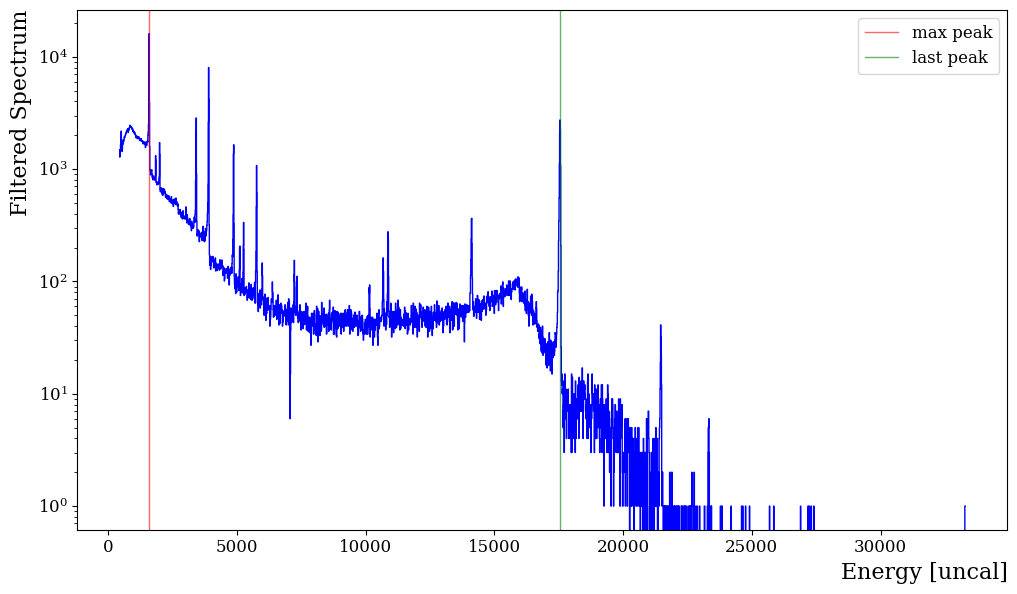

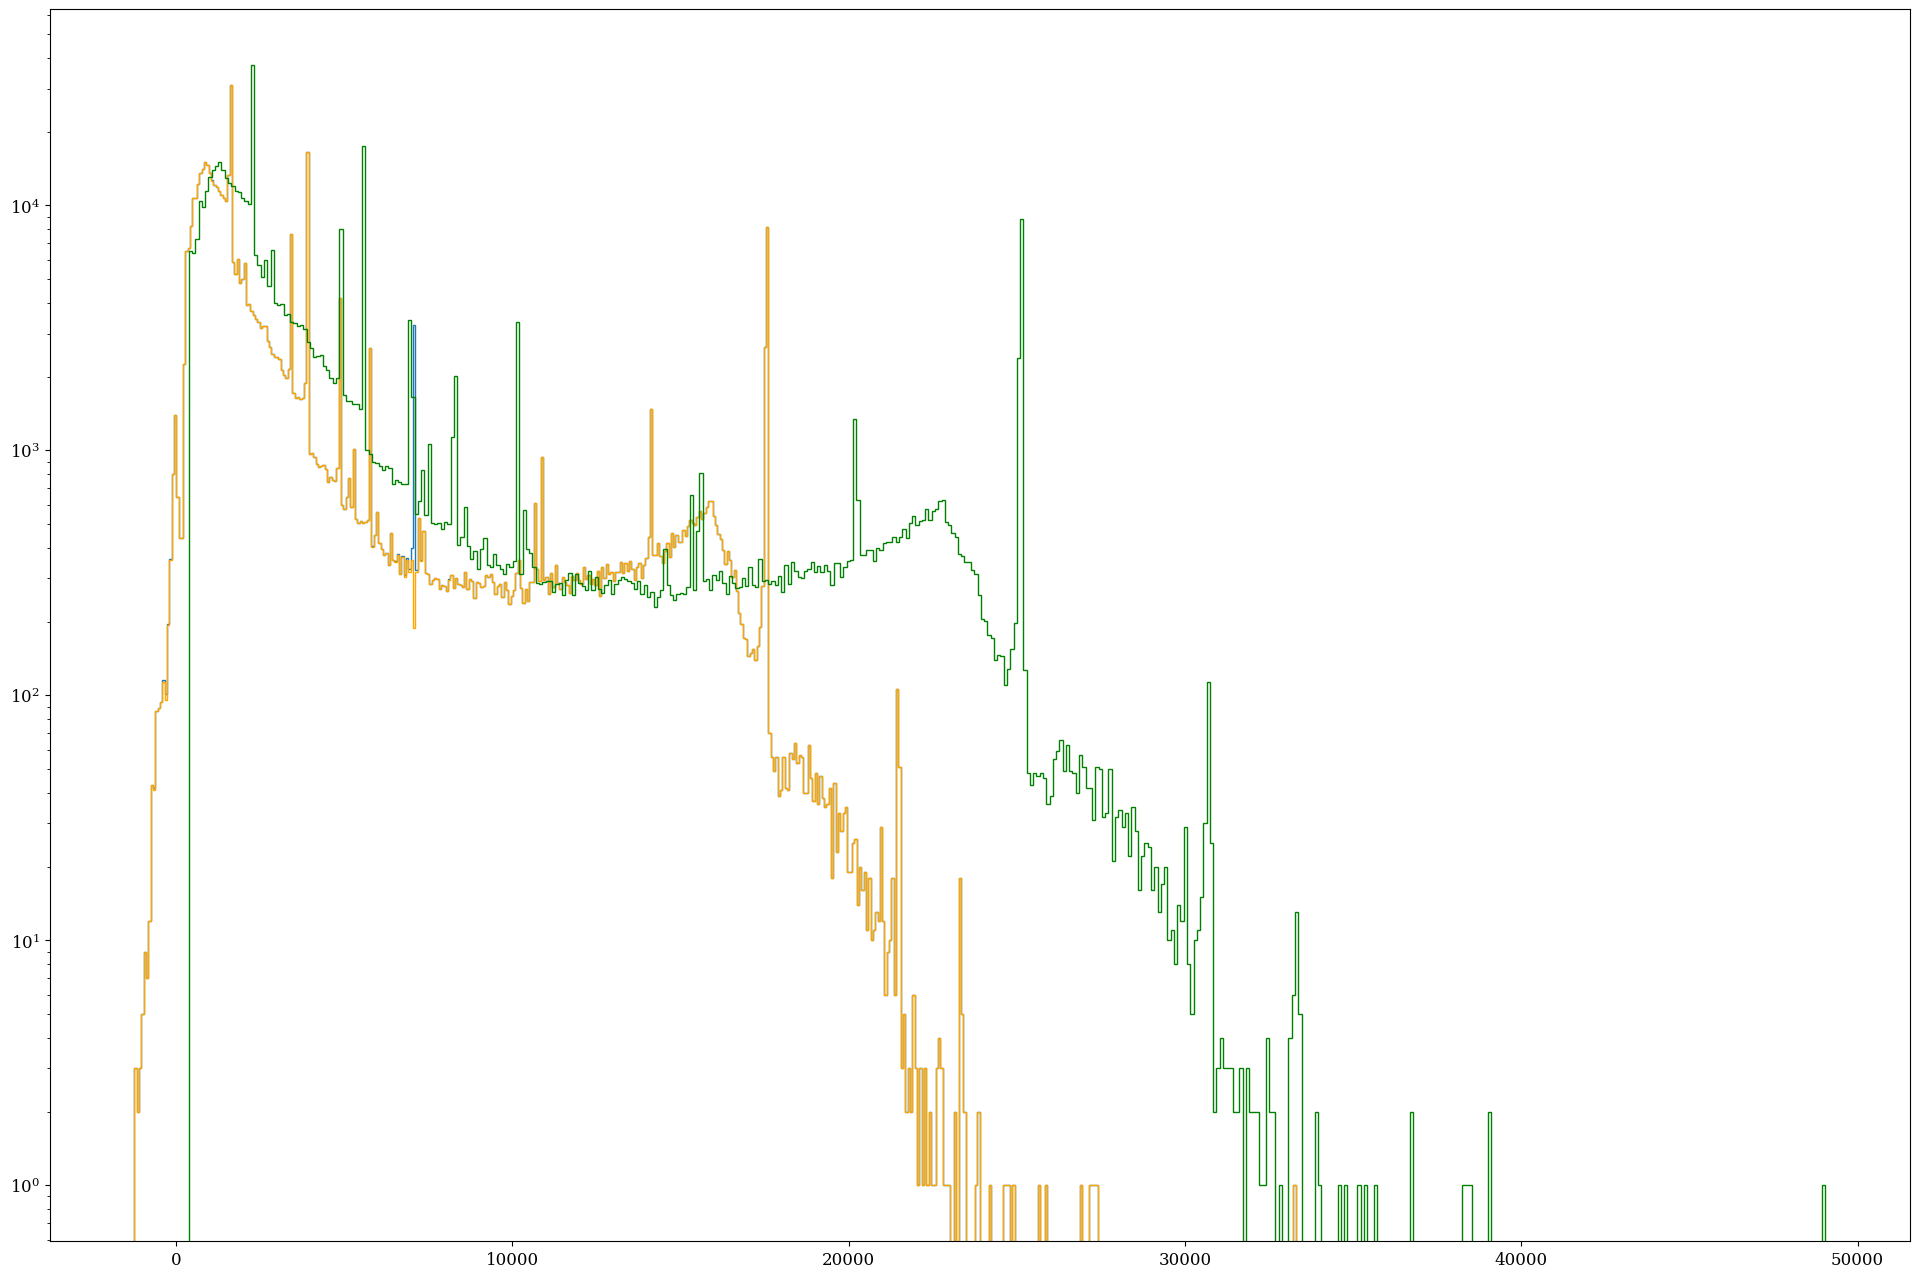

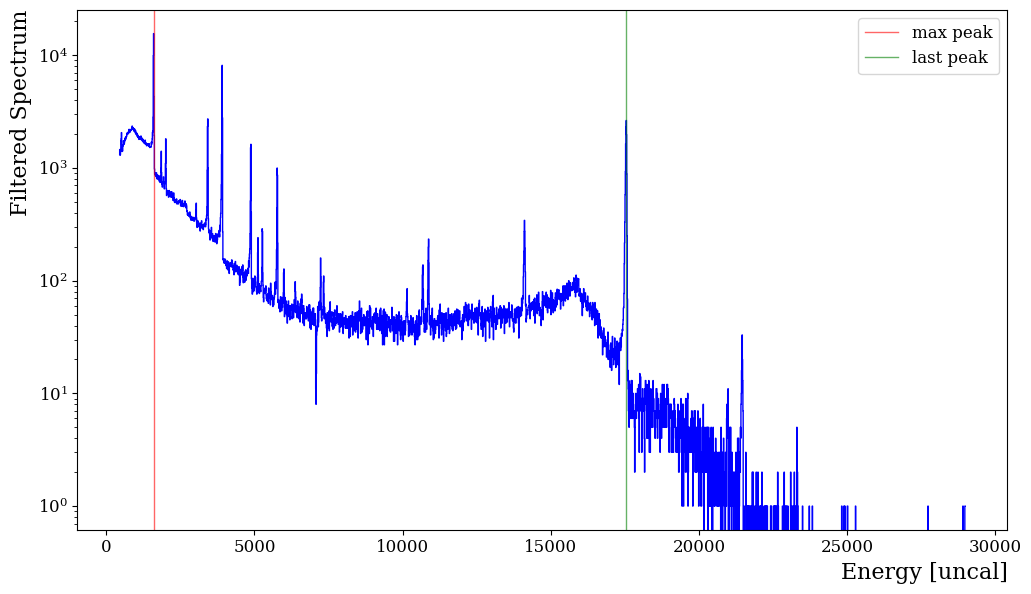

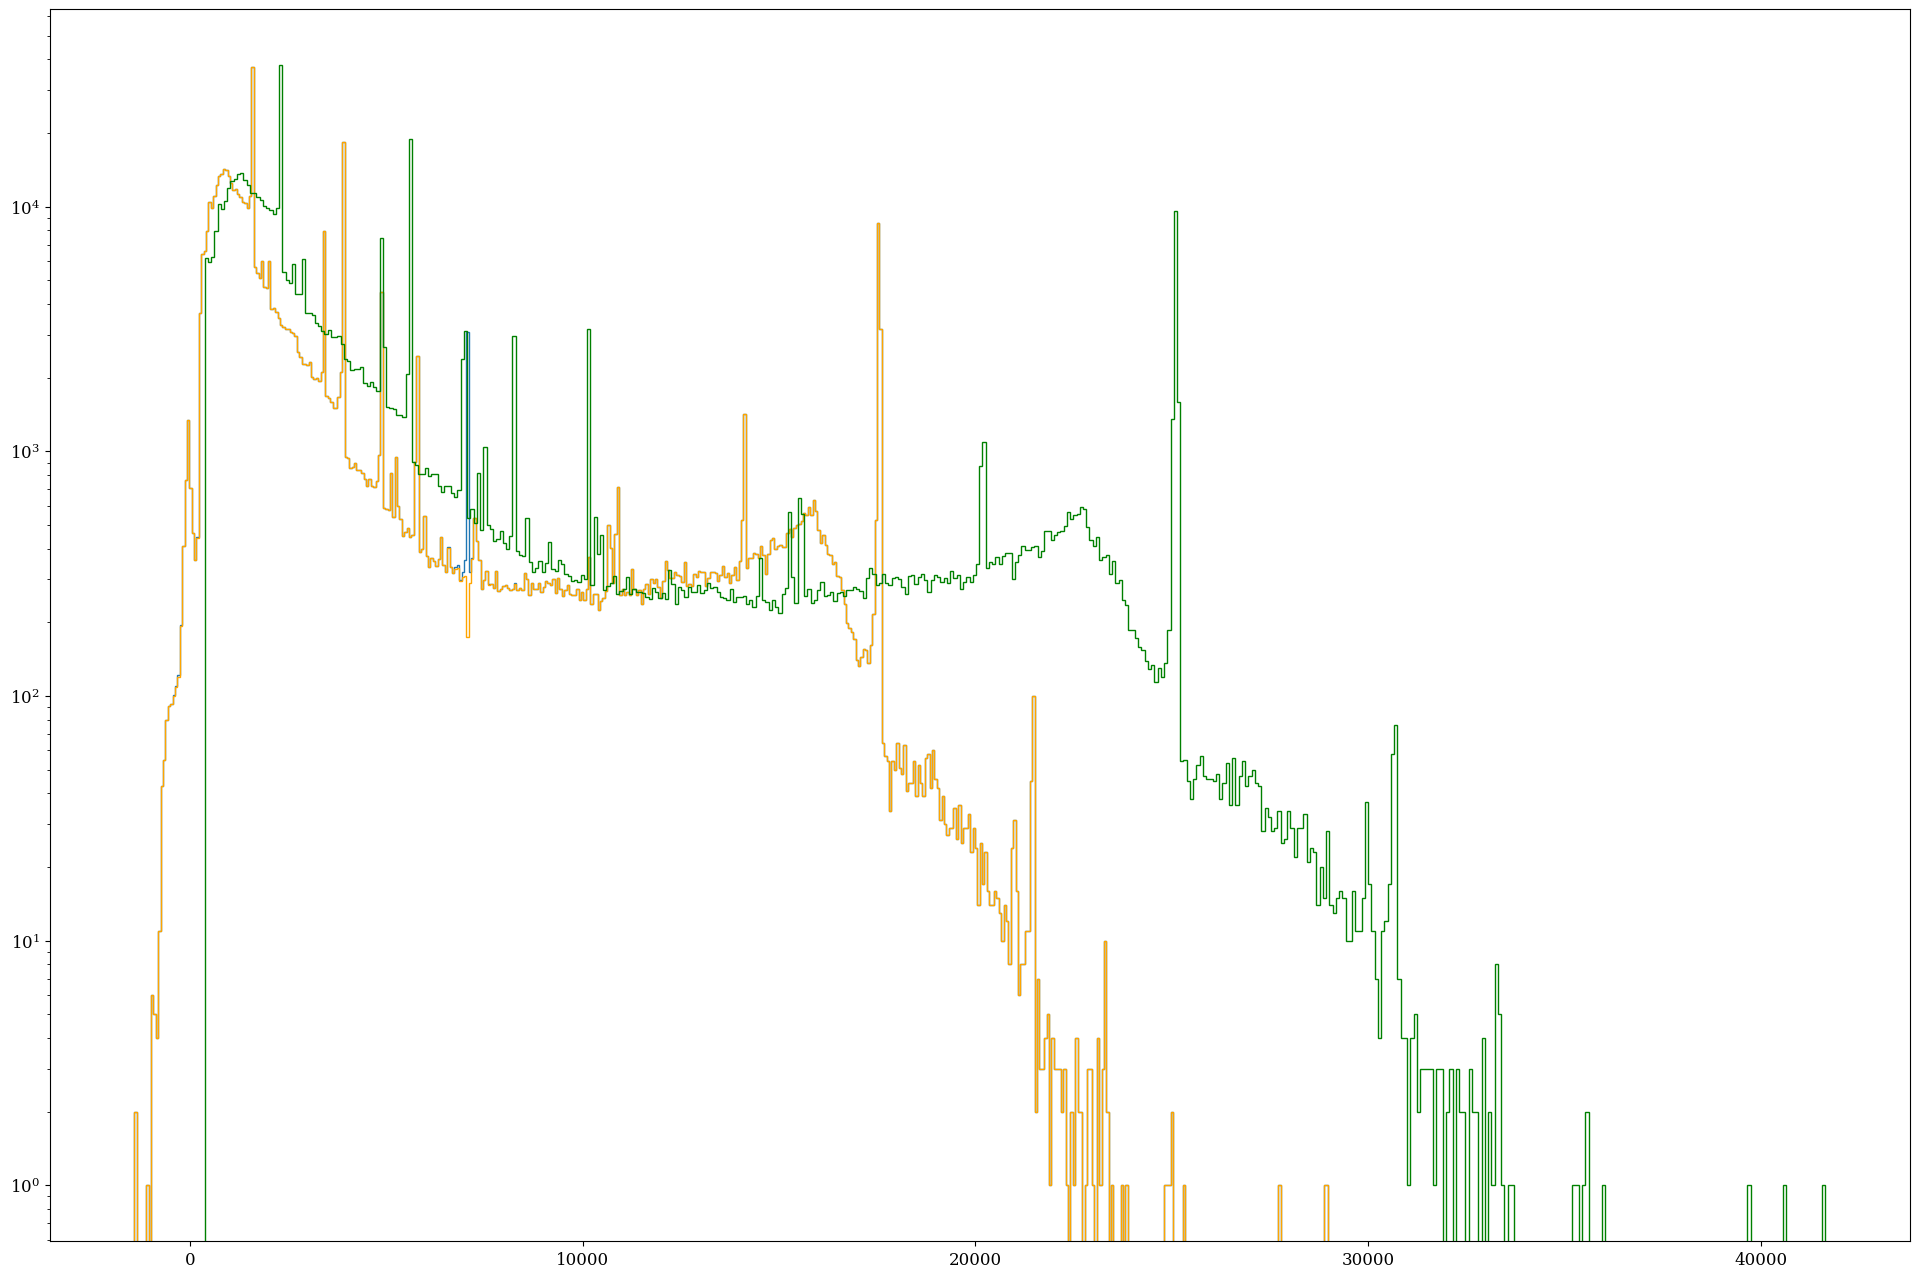

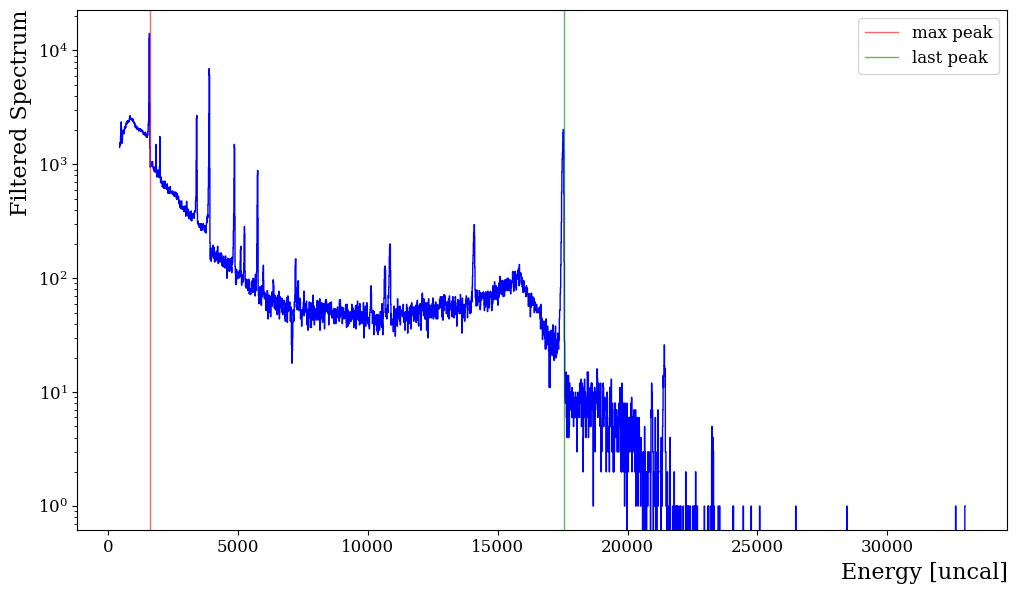

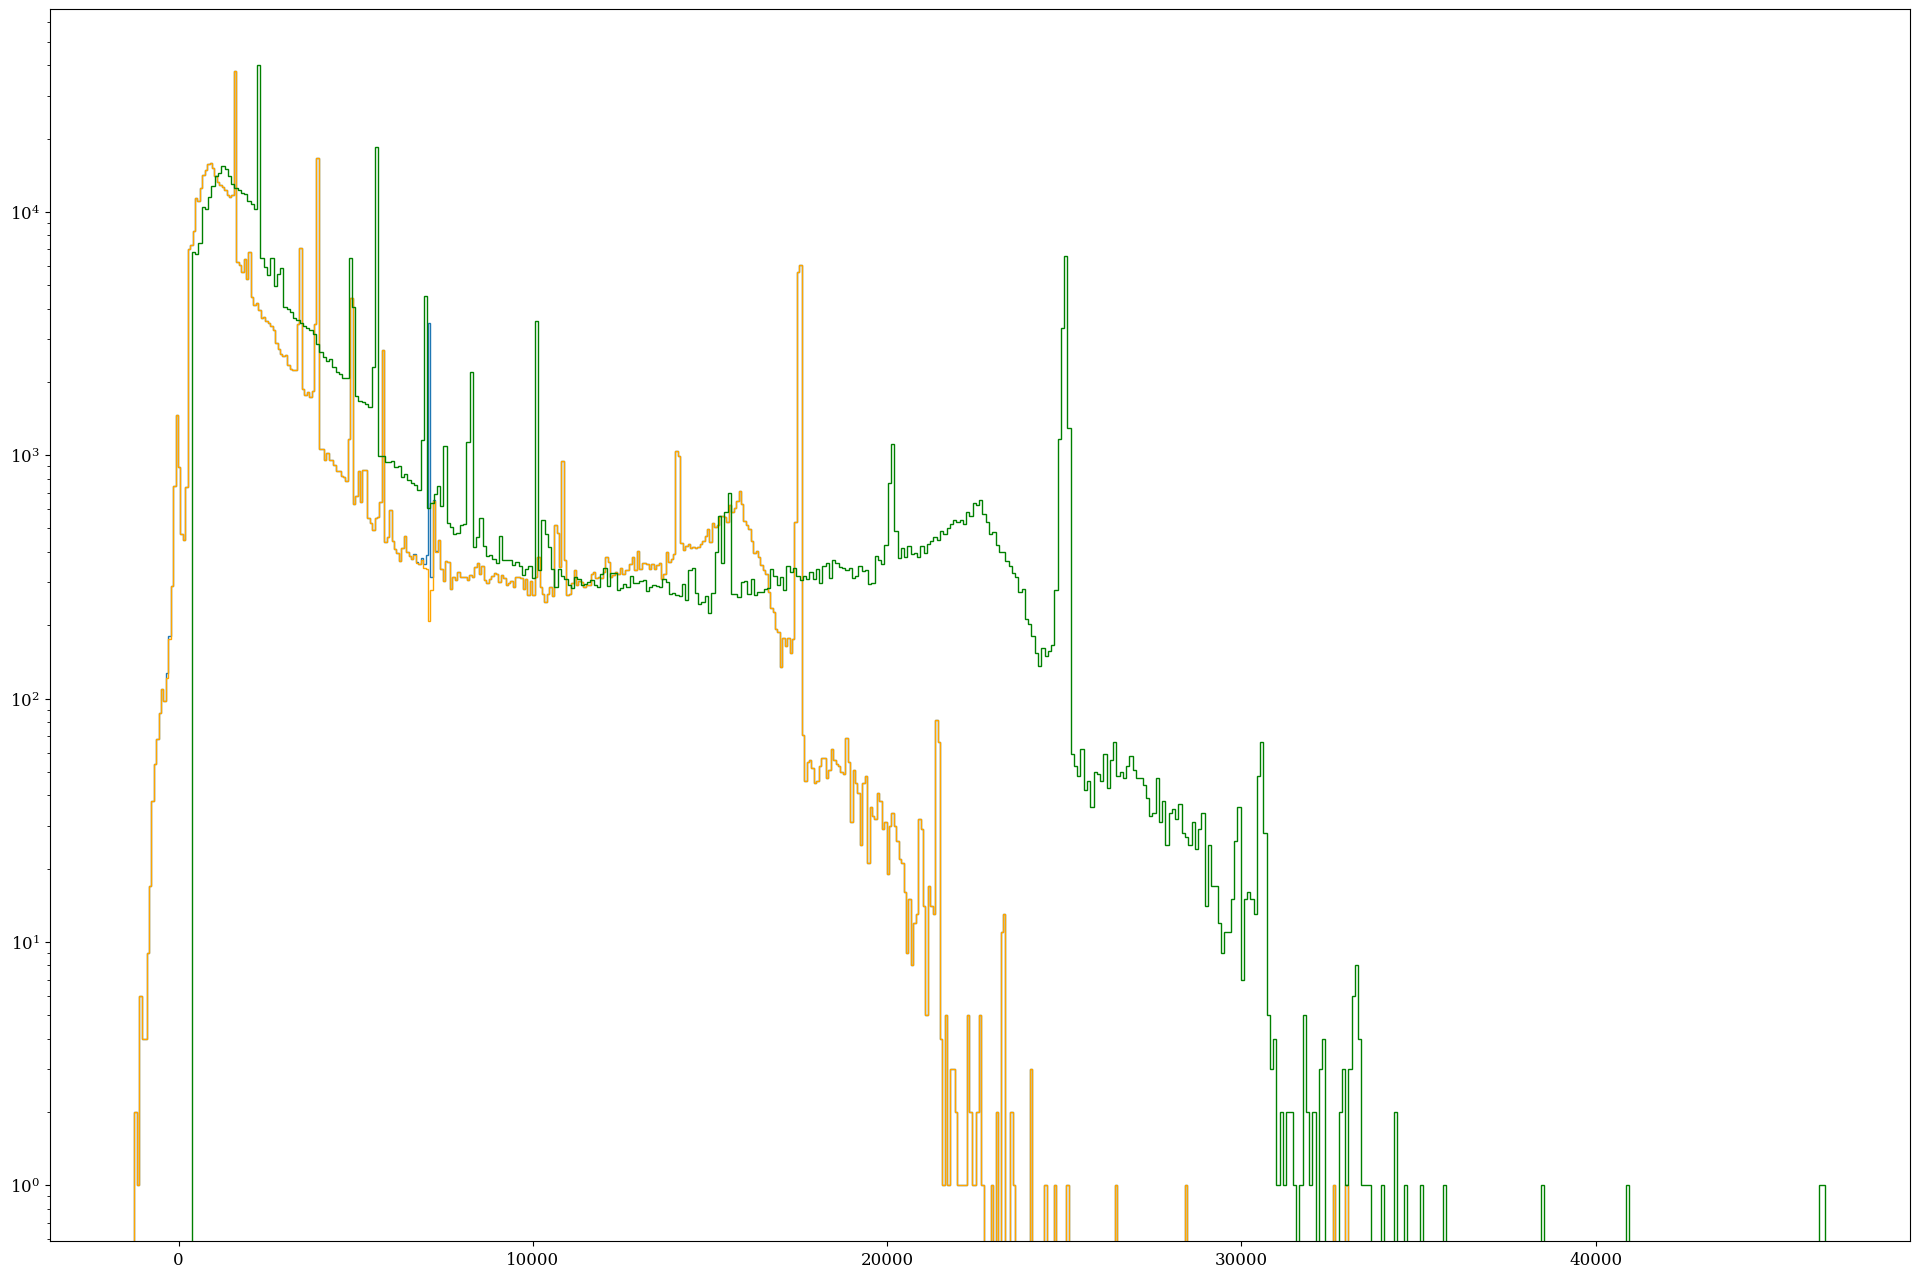

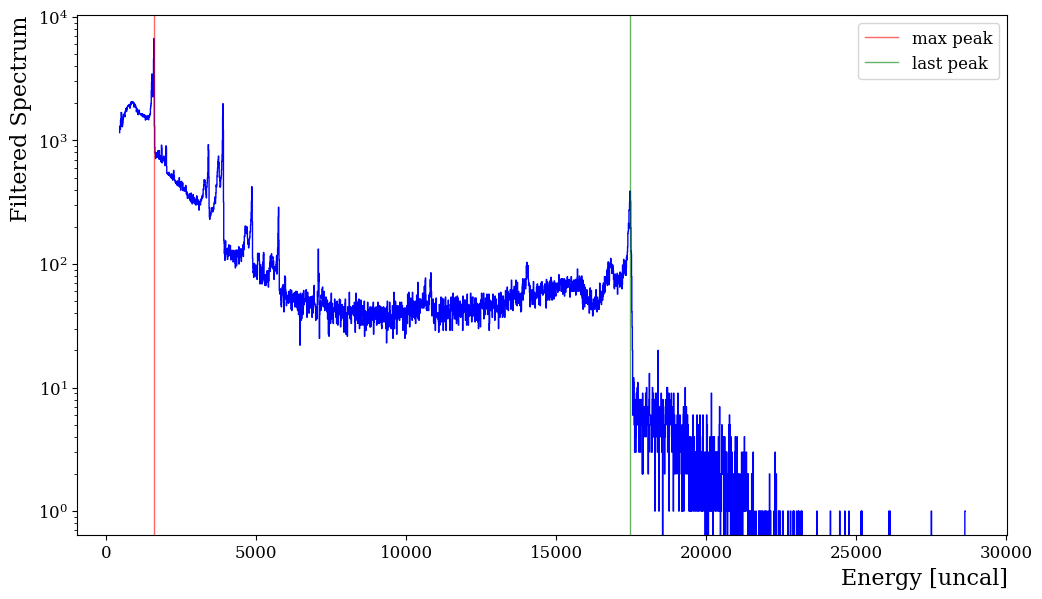

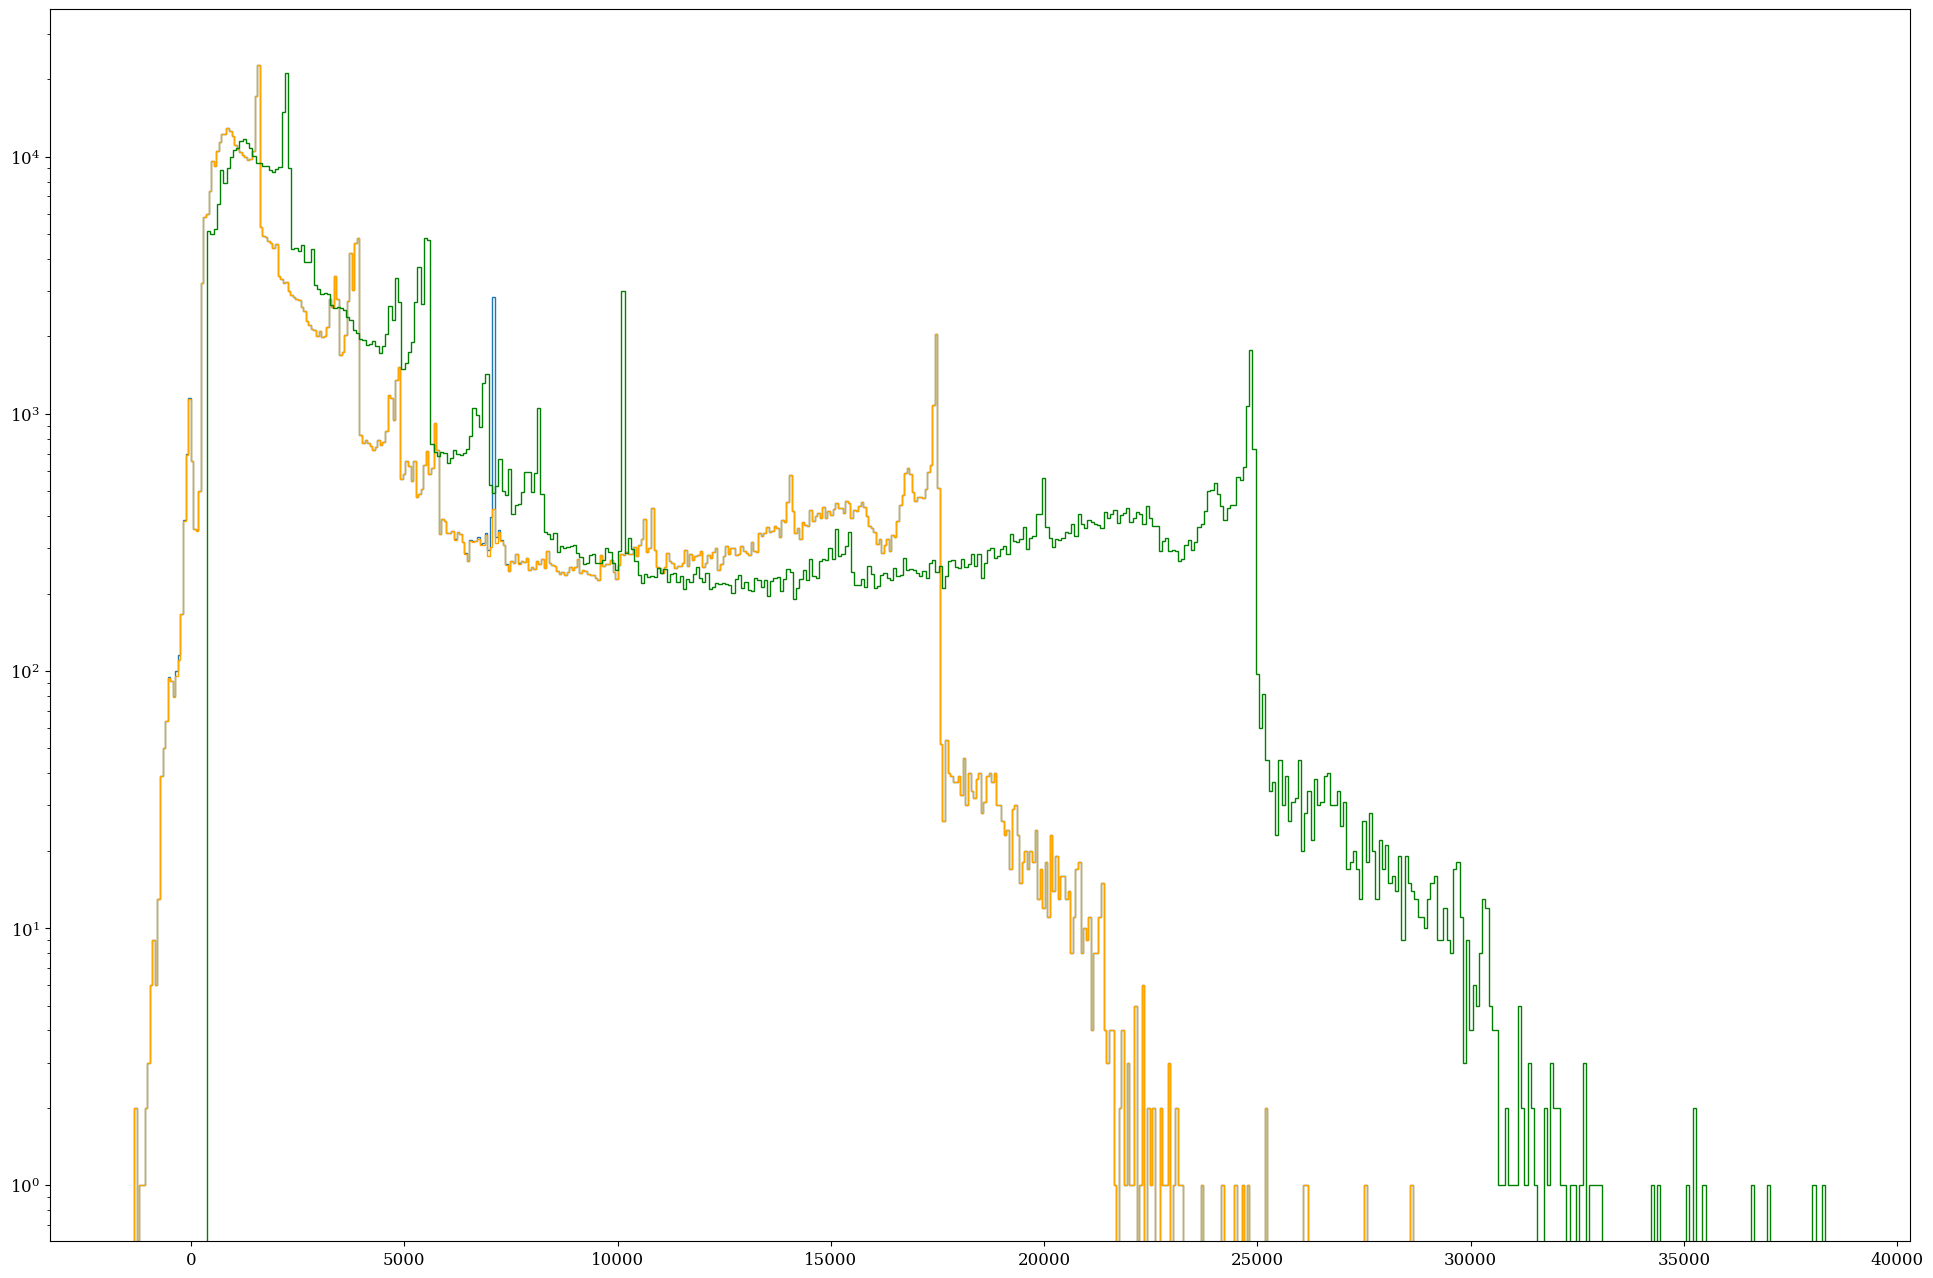

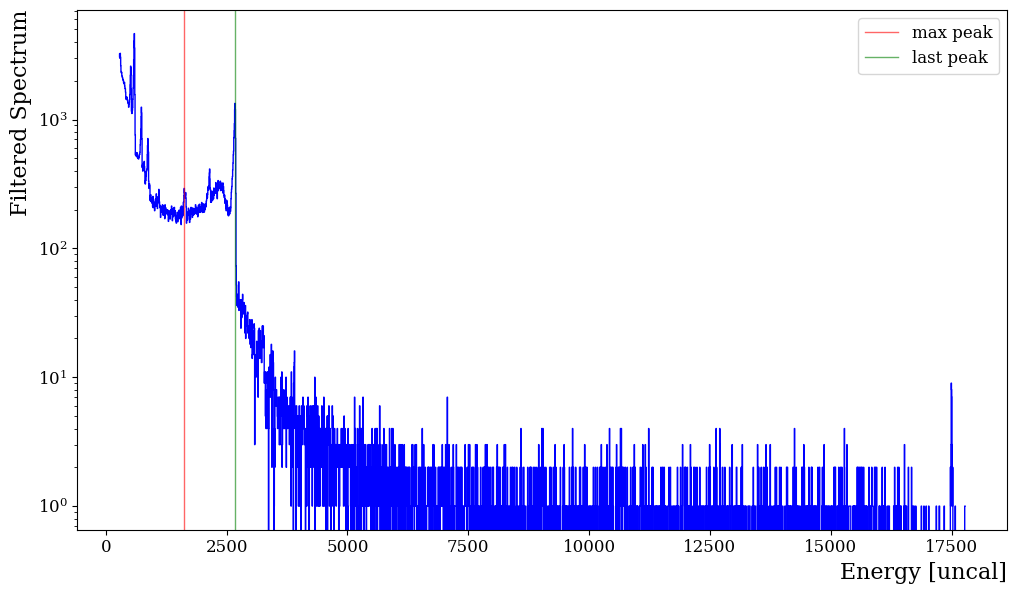

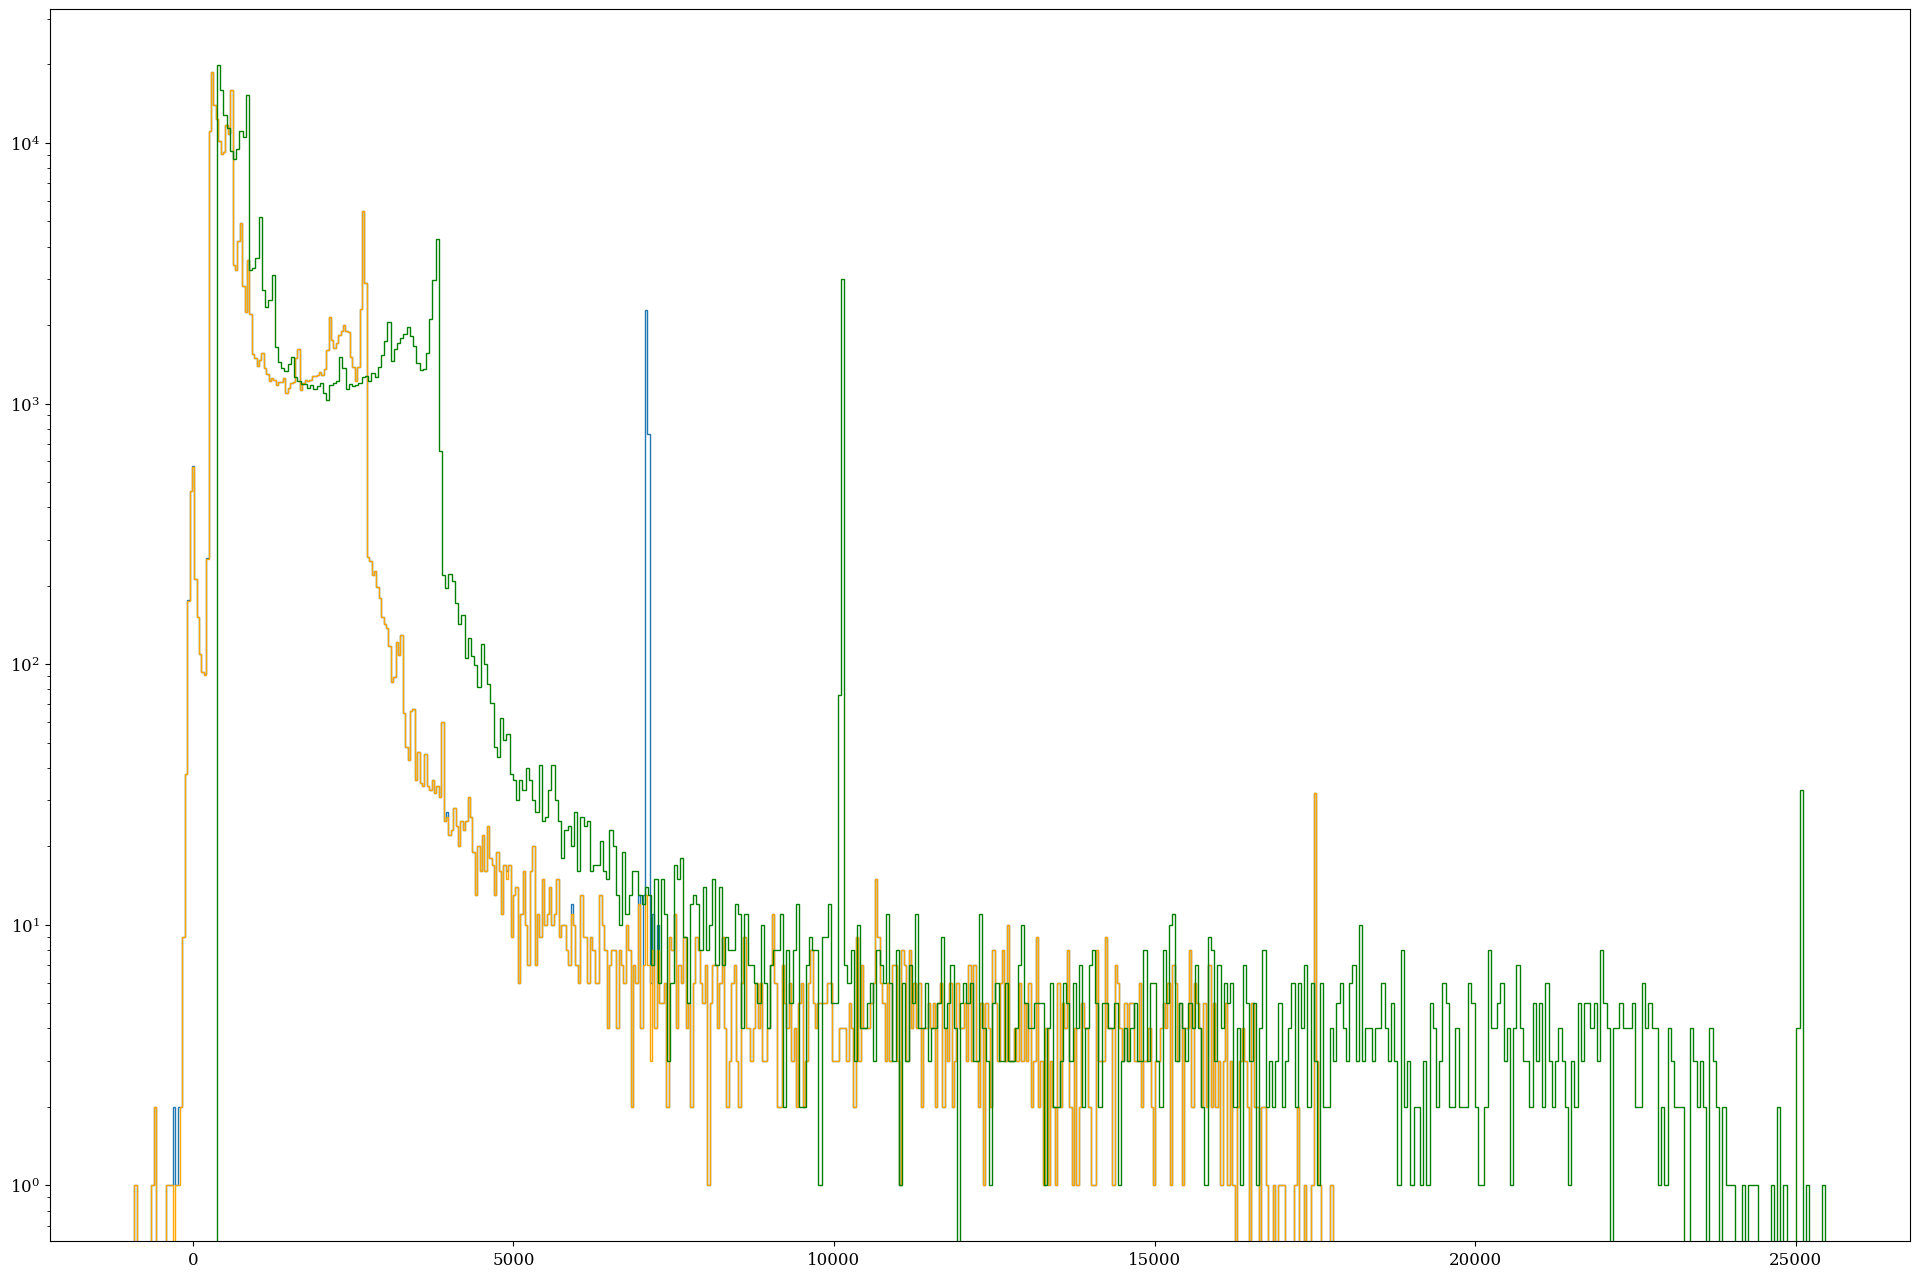

In [182]:
voltages = []
strings = []
positions = []
channels = []

exposures = []
energies = []
a_max = []
dt_eff = []

for det in detectors:
    print(det)
    
    if det.startswith('P0'):
        detector_type = "PPC"
    elif det.startswith('V0'):
        detector_type = 'ICPC'
    elif det.startswith('B'):
        detector_type = "BEGe"
    else:
        detector_type = "COAX"
    exposures_det = []
    energies_det = []
    a_max_det = []
    dt_eff_det = []
    try:
        voltage = np.array([float(vv) for vv in test_dict[det]['voltages']])
    except:
        voltage =  np.arange(100,1000,100, dtype=int)

    fcid = int(chmap[det]['daq']['rawid'])
    chn = f'ch{fcid:03}'
    string = int(chmap[det]['location']['string'])
    position = int(chmap[det]['location']['position'])
    
    mass_in_kg = dets_map[det]["production"]["mass_in_g"] / 1000
    
    for n_scan, dsp_list_scan in enumerate(dsp_list):
        if n_scan>4: continue
        print("scan", n_scan)
        exposures_scan = []
        energies_scan = []
        a_max_scan = []
        dt_eff_scan = []
        raw_list_scan = [file.replace("dsp", "raw") for file in dsp_list_scan]
        
        tstart = time.time()
        try:
            t_pulser = sto.read_object(f"ch1027201/dsp/timestamp", dsp_list_scan)[0]
            times_scan = sto.read_object(f"{chn}/dsp/timestamp", dsp_list_scan)[0]
            times_scan, t_pulser = times_scan.nda, t_pulser.nda
            nopulser_idxs = pulser_tag(times_scan, t_pulser, gap = 0.000001)
        except KeyError:    #if no pulser:
            times_scan = sto.read_object(f"{chn}/dsp/timestamp", dsp_list_scan)[0]
            daqenergy_scan = sto.read_object(f"{chn}/raw/daqenergy", raw_list_scan)[0]
            pulser_list = find_pulser_properties(det, daqenergy_scan,times_scan, energy="daqenergy")
            ids_pulser = find_pulser(daqenergy_scan, pulser_list)
            mask = ~ids_pulser
            nopulser_idxs = np.where(mask)[0]
            
    
        #exposure
        dt = datetime.fromtimestamp(times_scan[-1]) - datetime.fromtimestamp(times_scan[0])
        dt_seconds = dt.total_seconds()
        exposures_scan = mass_in_kg*dt_seconds
        
        #checks
        #time_cycle=len(pulser_idxs[pulser_idxs==False])*2#in seconds
        #energies_pulser = energies[(~pulser_idxs)]
        #times_pulser = times[(~pulser_idxs)]

        #energies_scan = energies_scan[pulser_idxs]
        energies_scan = sto.read_object(f"{chn}/dsp/cuspEmax", dsp_list_scan, idx=nopulser_idxs)[0]      
        a_max_scan = sto.read_object(f"{chn}/dsp/A_max", dsp_list_scan, idx=nopulser_idxs)[0]
        dt_eff_scan = sto.read_object(f"{chn}/dsp/dt_eff", dsp_list_scan, idx=nopulser_idxs)[0]
        
        energies_scan, a_max_scan, dt_eff_scan = energies_scan.nda, a_max_scan.nda, dt_eff_scan.nda
        
        ##only for visualization - set plot=True
        peak_max, peak_last = get_first_last_peaks(energies_scan, detector_type, pulser=False,plot=True)
        #energy calibration
        energies_scan = en_calibration(energies_scan, detector_type, 0.01)
        
        fig, axis = plt.subplots(figsize=(24,16), facecolor='white')
        #plt.hist(energies_scan, bins=500, histtype="step")
        plt.hist(sto.read_object(f"{chn}/dsp/cuspEmax", dsp_list_scan)[0], bins=500, histtype="step")
        plt.hist(sto.read_object(f"{chn}/dsp/cuspEmax", dsp_list_scan, idx=nopulser_idxs)[0], bins=500, histtype="step")
        plt.hist(daqenergy_scan, bins=500, histtype="step")
        plt.yscale('log')
        
        exposures_det.append(exposures_scan)
        energies_det.append(energies_scan)
        a_max_det.append(a_max_scan)
        dt_eff_det.append(dt_eff_scan)
        
        print('\nperiod',n_scan+1,'HV',voltage[n_scan], 'time',dt_seconds,'s')
        print('n.events',len(times_scan)) #,len(t_pulser)
        
    voltages.append(voltage)
    strings.append(string)
    positions.append(position)
    channels.append(chn)
    exposures.append(exposures_det)
    energies.append(energies_det)
    a_max.append(a_max_det)
    dt_eff.append(dt_eff_det)

## Energy spectrum

In [138]:
print(energies[0])

[array([139.32011, 601.8621 , 135.68442, ..., 167.8144 , 219.3489 ,
       810.81665], dtype=float32), array([165.65501 , 215.01071 , 233.74626 , ..., 324.2377  ,  47.933388,
        43.364437], dtype=float32), array([  87.483665, 1455.3594  , 2198.965   , ...,  126.49452 ,
        368.79266 ,   74.084984], dtype=float32), array([ 131.60199, 1005.6475 ,  219.01491, ...,  139.4301 ,  123.0119 ,
        171.03035], dtype=float32), array([-364.0662 , -381.14282, -339.8861 , ..., -386.10776, -117.2814 ,
       1351.5979 ], dtype=float32), array([155.04155, 166.60548,  54.21555, ...,  97.9219 , 363.24832,
       141.97585], dtype=float32), array([ 473.94263,  213.79442,  988.00433, ..., 1192.6051 ,  201.99634,
        181.21397], dtype=float32), array([ 188.38435,  137.49232,  205.92958, ...,  255.55214,  573.80414,
       1341.699  ], dtype=float32), array([ 166.60657 ,  152.63106 ,   92.400604, ...,  322.60306 ,
       1631.5668  ,  108.05477 ], dtype=float32)]


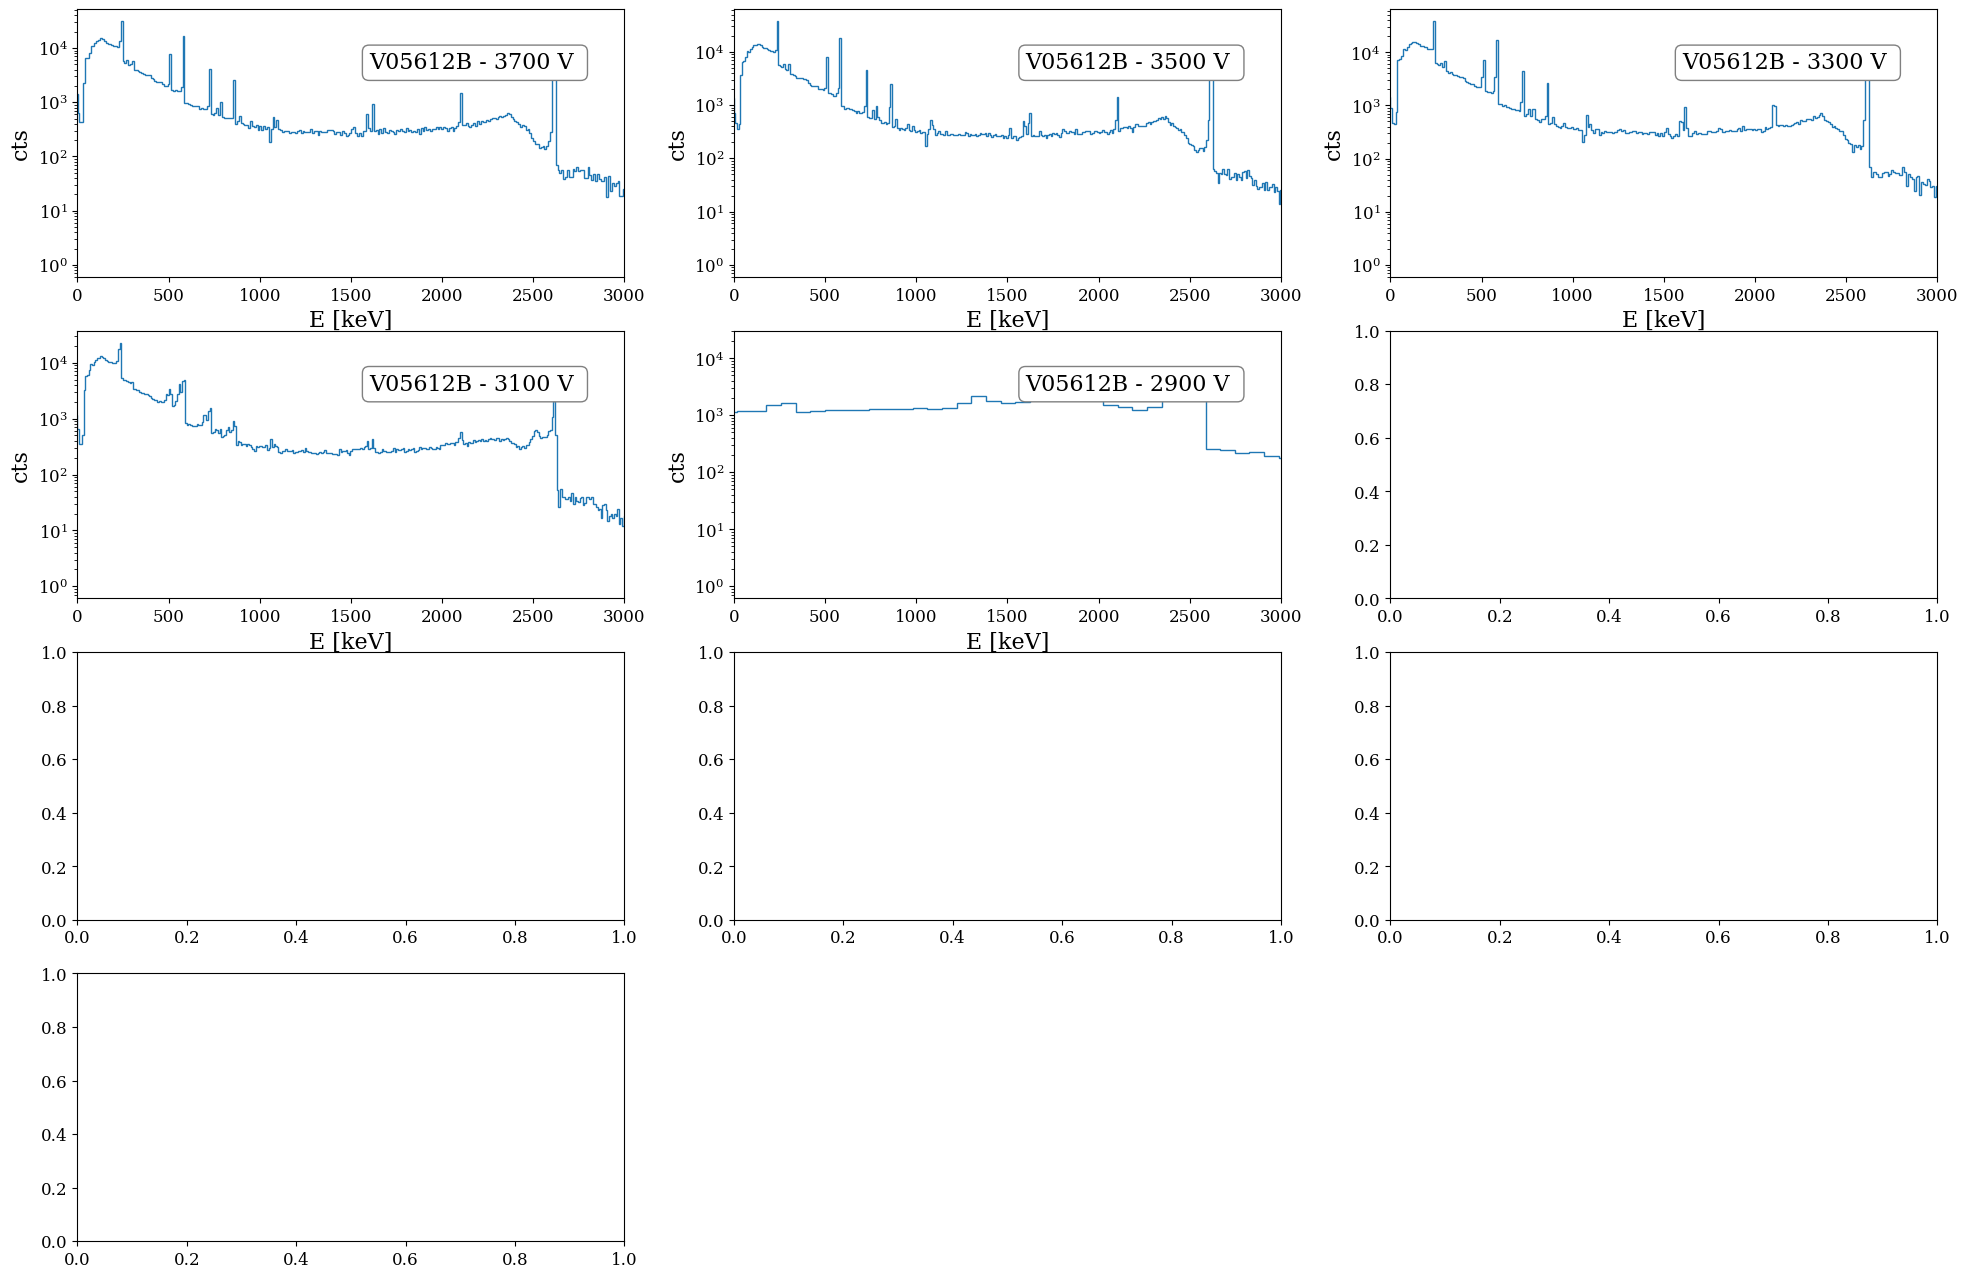

In [183]:
fig, axis = plt.subplots(nrows=4, ncols=3, figsize=(24,16), facecolor='white')
axis[3][1].axis('off')
axis[3][2].axis('off')

nscan = 0
for energies_scan,  voltages_scan in zip(energies[n_det], voltages[n_det]):
    ax = axis.flat[nscan]
    ax.hist(energies_scan, bins=500, histtype="step")
    ax.set_yscale("log")
    ax.set_xlabel('E [keV]')
    ax.set_ylabel('cts')
    ax.set_xlim((0,3000))
    ax.annotate(f'{detectors[n_det]} - {voltages_scan:.0f} V ', xy=(210, 150), xycoords='axes points',
            size=16, bbox=dict(boxstyle='round', fc='w',  edgecolor='grey') )   
    nscan+=1
    
if save_fig == True:
    savefig(fig, detectors[n_det], "energy_spectrum")

## A spectrum

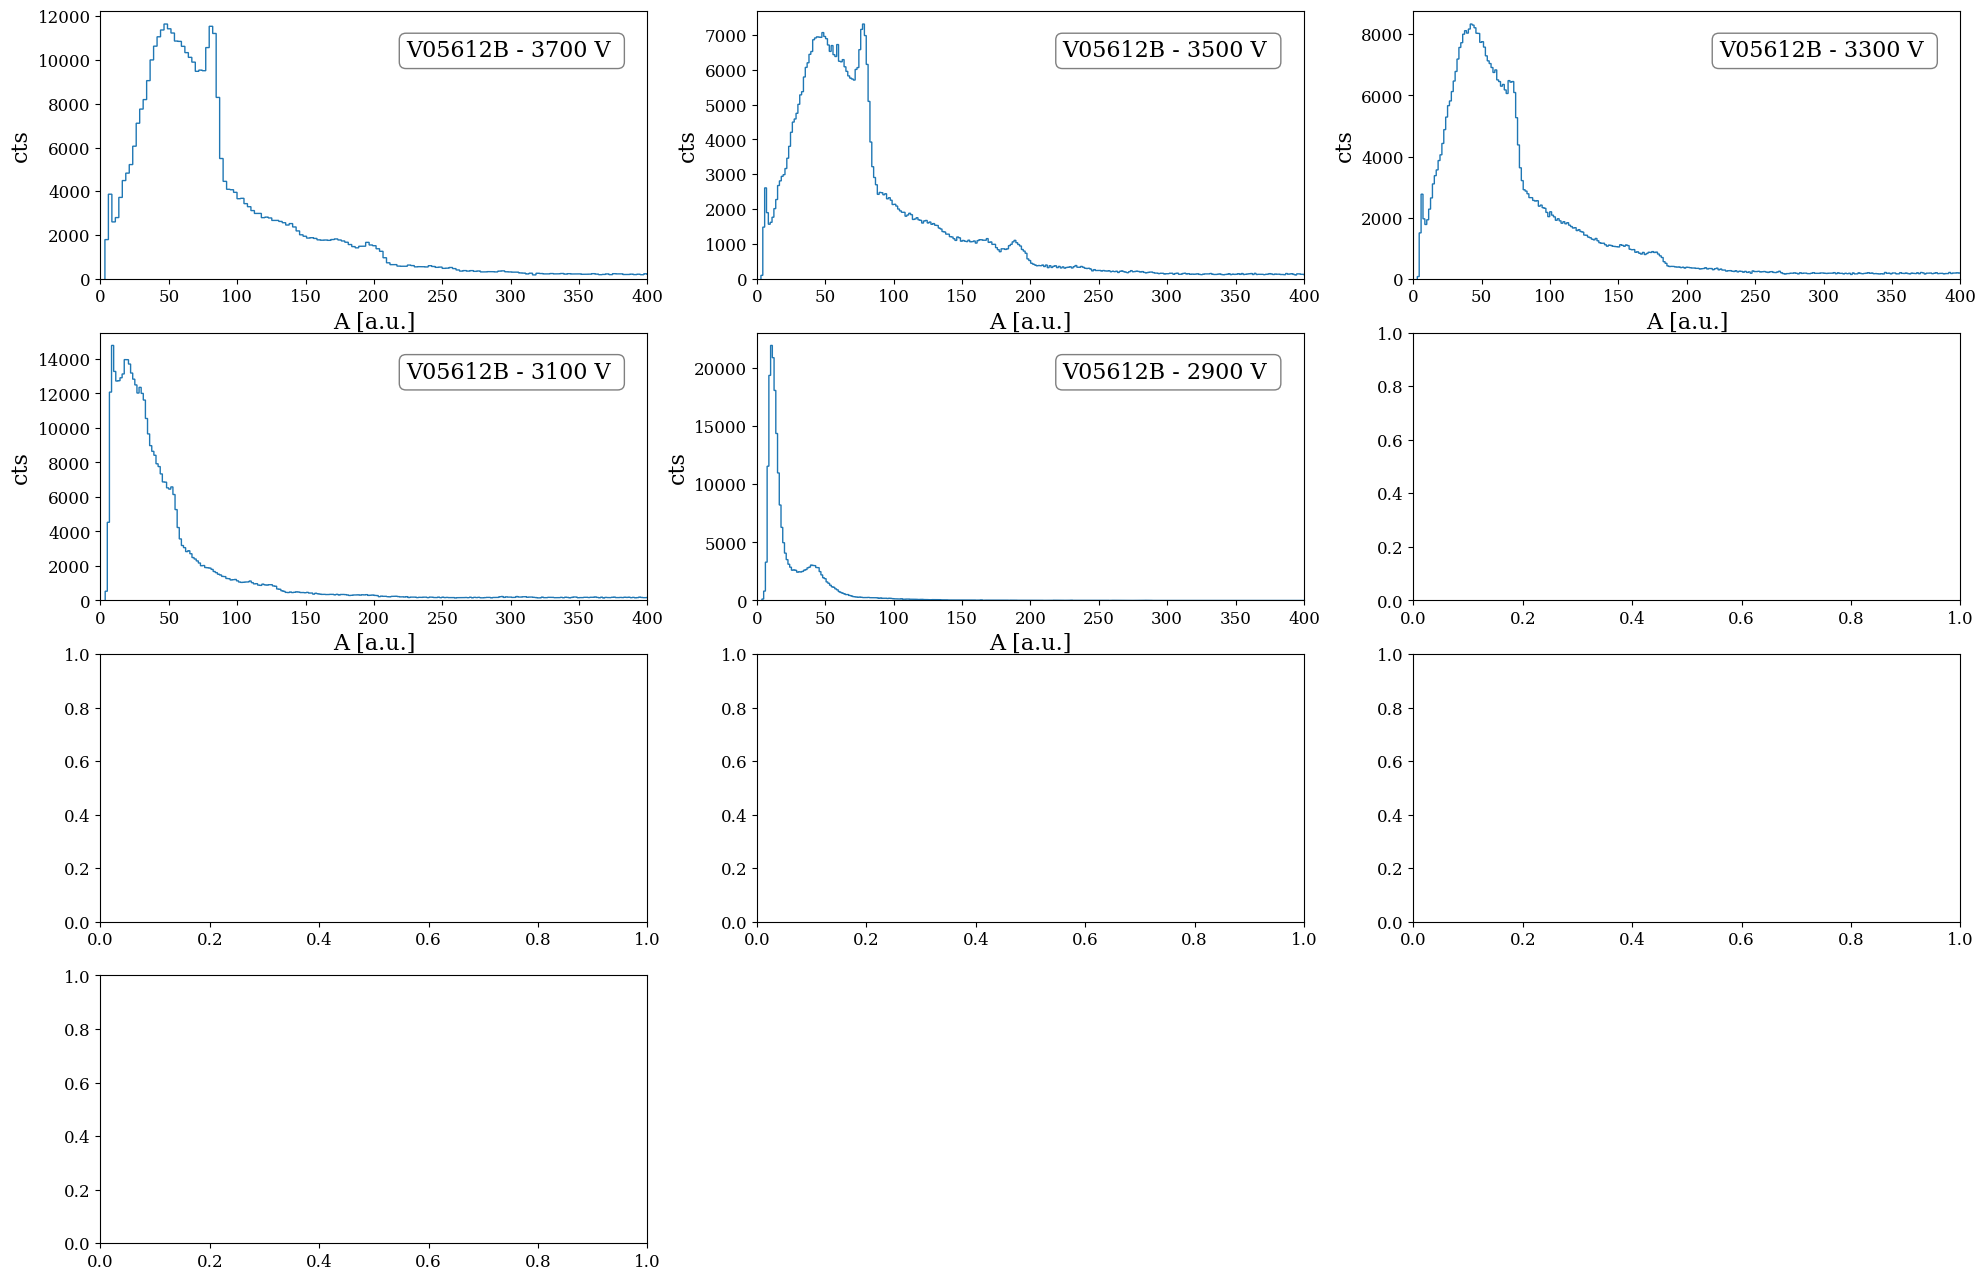

In [184]:
fig, axis = plt.subplots(nrows=4, ncols=3, figsize=(24,16), facecolor='white')
axis[3][1].axis('off')
axis[3][2].axis('off')

nscan = 0
for a_max_scan,  voltages_scan in zip(a_max[n_det], voltages[n_det]):
    ax = axis.flat[nscan]
    ax.hist(a_max_scan, bins=1000, histtype="step")
    ax.set_xlabel('A [a.u.]')
    ax.set_ylabel('cts')
    ax.set_xlim((0,400))
    ax.annotate(f'{detectors[n_det]} - {voltages_scan:.0f} V ', xy=(220, 160), xycoords='axes points',
            size=16, bbox=dict(boxstyle='round', fc='w',  edgecolor='grey') )        
    nscan+=1

if save_fig == True:
    savefig(fig, detectors[n_det], "A_spectrum")

## A/E vs E

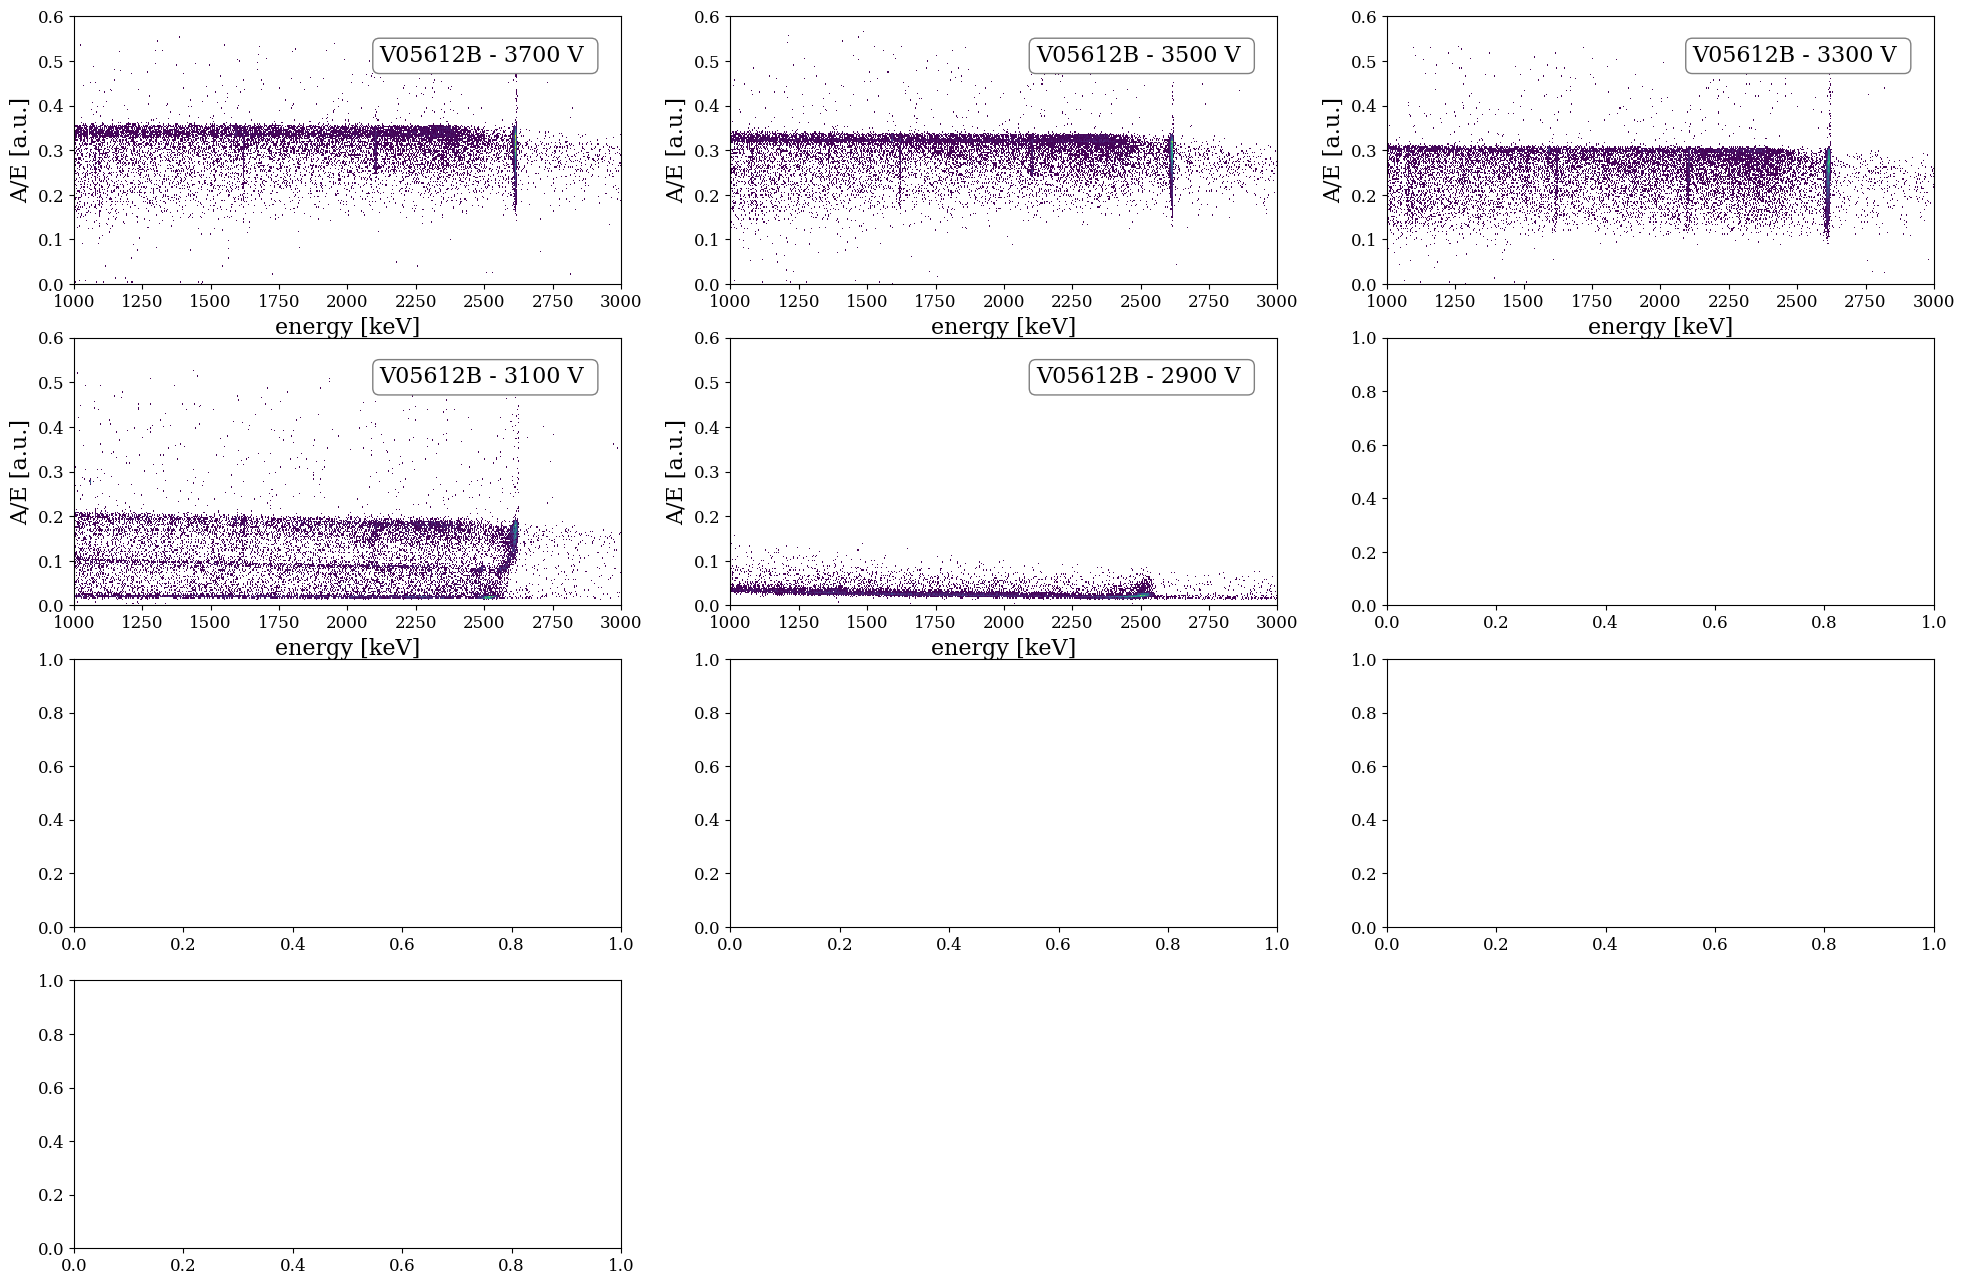

In [185]:
fig, axis = plt.subplots(nrows=4, ncols=3, figsize=(24,16), facecolor='white')
axis[3][1].axis('off')
axis[3][2].axis('off')

nscan = 0
for a_max_scan, energies_scan, voltages_scan in zip(a_max[n_det], energies[n_det], voltages[n_det]):
    ax = axis.flat[nscan]
    aoe = a_max_scan/energies_scan
    cut = (energies_scan>1000) & (aoe< 2)
    ax.hist2d(energies_scan[cut], aoe[cut], bins=(2000,200), range=([1000,3000],[0.0,0.6]), cmin = 1)
    ax.set_xlabel('energy [keV]')
    ax.set_ylabel('A/E [a.u.]')
    ax.set_xlim((1000,3000))     
    ax.annotate(f'{detectors[n_det]} - {voltages_scan:.0f} V ', xy=(220, 160), xycoords='axes points',
        size=16, bbox=dict(boxstyle='round', fc='w',  edgecolor='grey') )
    nscan+=1
    
if save_fig == True:
    savefig(fig, detectors[n_det], "AoE_vs_E")

## Drift time vs A/E

#### Which A/E fit function?

In [186]:
#pdf with or without tail
pdf_fit = aoe_cal.standard_aoe_with_high_tail #aoe_cal.standard_aoe

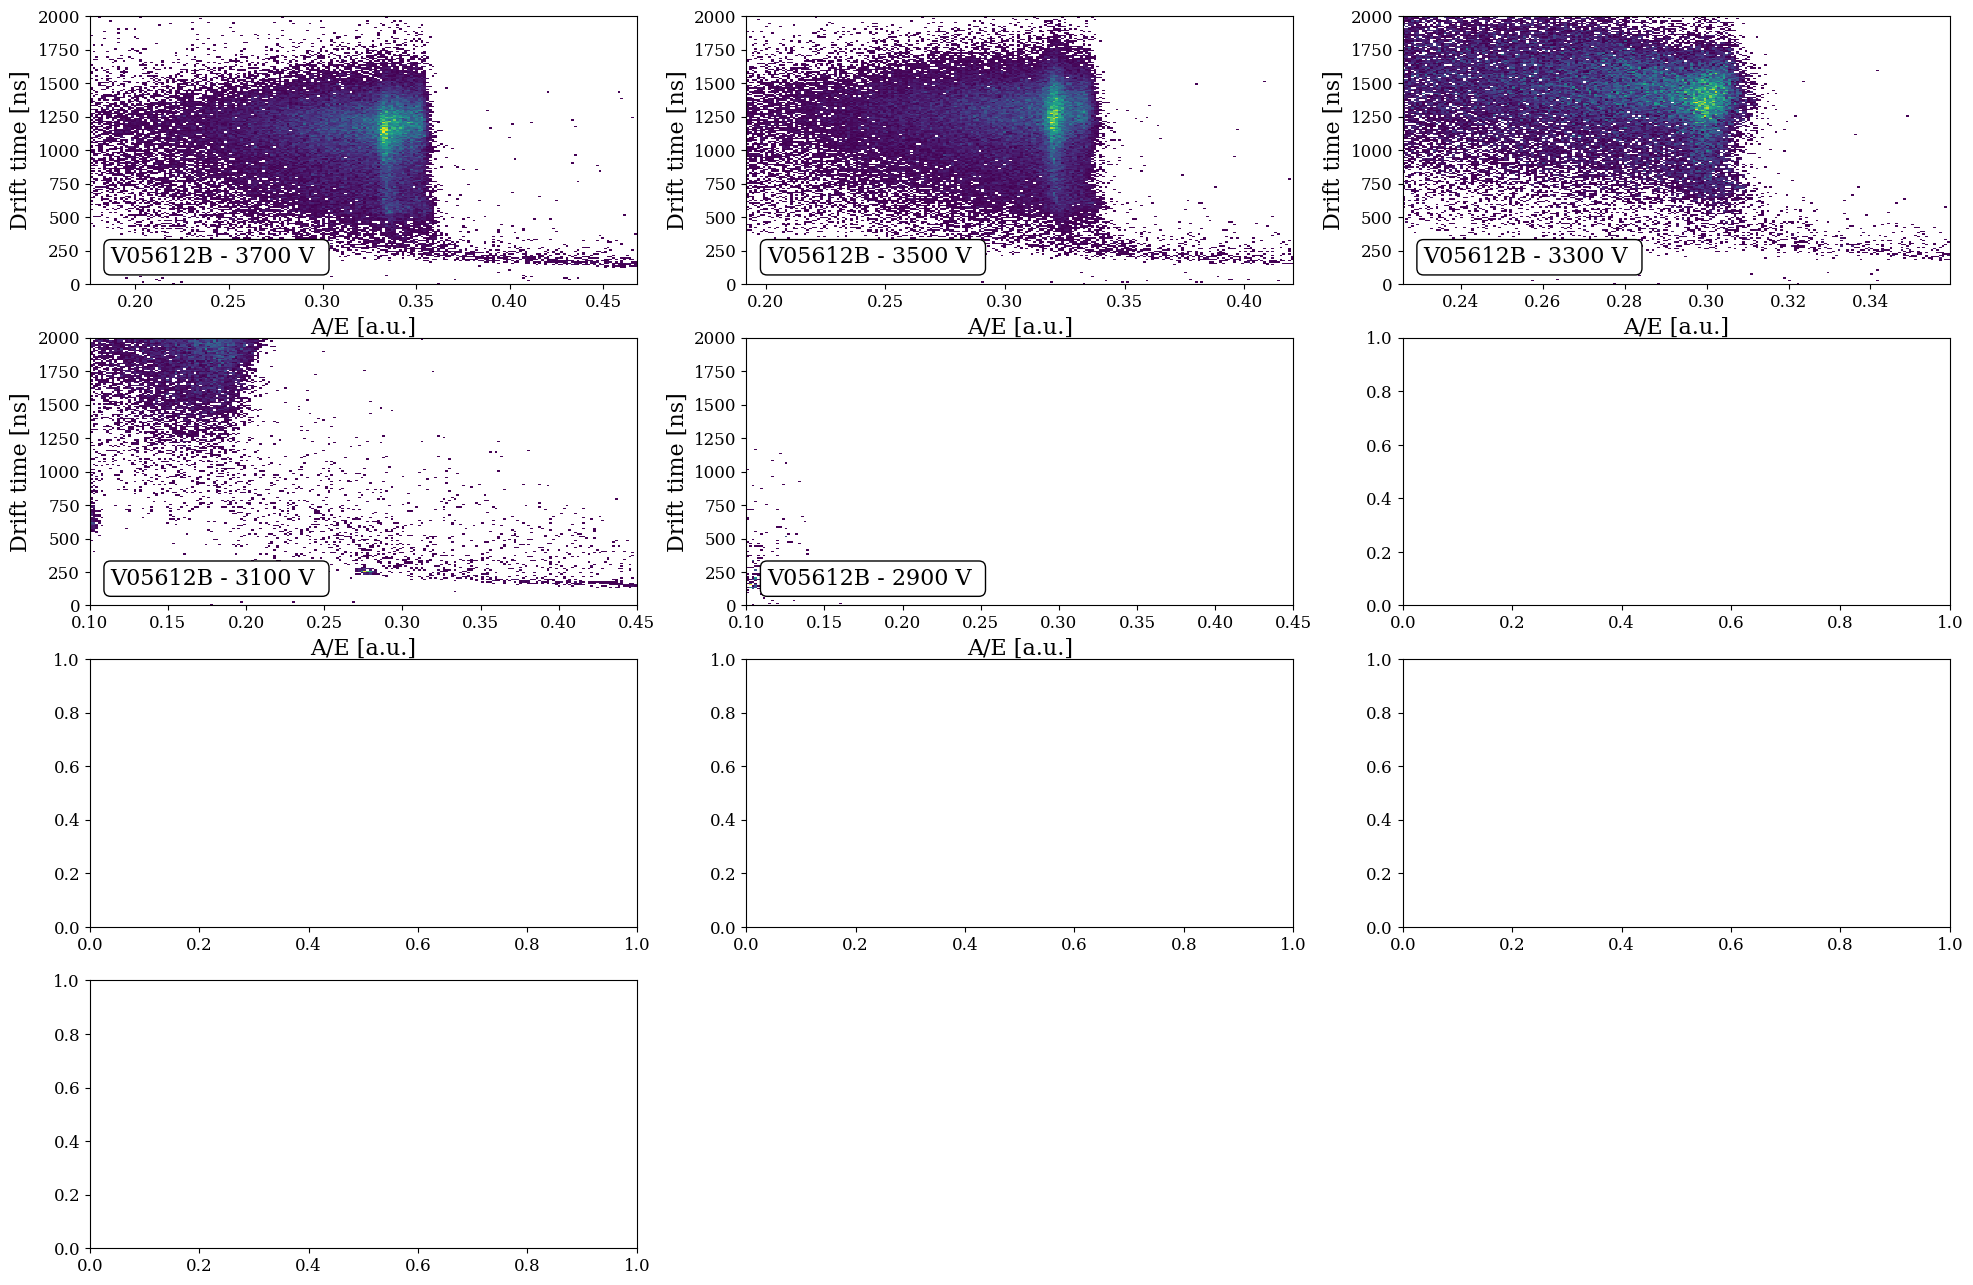

In [187]:
fig, axis = plt.subplots(nrows=4, ncols=3, figsize=(24,16), facecolor='white')
axis[3][1].axis('off')
axis[3][2].axis('off')

if detector_type == "PPC":
    dt_max=1000
elif detector_type != "PPC" and detectors[n_det]!="V05268B":
    dt_max=2000
else:
    dt_max=2000

nscan = 0
for a_max_scan, energies_scan, dt_eff_scan, voltages_scan in zip(a_max[n_det],energies[n_det],dt_eff[n_det], voltages[n_det]):
    cuts_titles = ['>1MeV']#,'DEP', 'DEP']
    cuts = [(energies_scan>1000)] #, ( (energies_scan>1000) & (energies_scan<1400) ),( (energies_scan>1700) & (energies_scan<2100))]
    for idx, cut in enumerate(cuts):
        ax = axis.flat[nscan]
        aoe = a_max_scan/energies_scan
        dt_eff_cut=dt_eff_scan[(cut) & (aoe<1000)]     
        aoe = aoe[(cut) & (aoe<1000)] 
        par, err, migrad, _ = aoe_cal.unbinned_aoe_fit(aoe, pdf=pdf_fit, display=0)
        mu = par[1]
        sigma = par[2]
        fmin = mu - 20 * sigma
        fmax = mu + 15 * sigma
        if fmin<0:
            fmin=0.1
            fmax=0.45
        ax.hist2d(aoe, dt_eff_cut, bins=(200,200), range=((fmin,fmax),(0,dt_max)), cmin=1)
        ax.set_ylabel('Drift time [ns]')
        ax.set_xlabel('A/E [a.u.]')
        ax.annotate(f'{detectors[n_det]} - {voltages_scan:.0f} V ', xy=(15, 15), xycoords='axes points',
            size=16, bbox=dict(boxstyle='round', fc='w') )   
    nscan+=1

if save_fig == True:
    savefig(fig, detectors[n_det], "drift-time_vs_AoE")

## A/E distribution study

#### A/E study Settings

### A/E distribution (blobs)

In [188]:
#study of the S/B through maxima ratio and integral ratio
SoB = True

if SoB==True:
    SoB_max_array = []
    SoB_3sigma_array = []

voltage 3700.0
True
0.17558146723815232 0.4680102012892791
S/B max 1.0949410399741761
S/B 3sigma 32190881786.942596


voltage 3500.0
True
0.19192001997543684 0.4204764821766003
S/B max 1.9200246818084554
S/B 3sigma 22300.106603166612


voltage 3300.0
True
0.22583686527831875 0.35935523479214104
S/B max 0.9776196888830034
S/B 3sigma 286963.0951190416


voltage 3100.0
True
-0.015147243958888529 0.04422901337324776
S/B max 324.7416214153171
S/B 3sigma 60546.72559262533


voltage 2900.0
True
-0.034447116161239424 0.059661909337237425
S/B max 540.7015921264446
S/B 3sigma 84246.4902961513




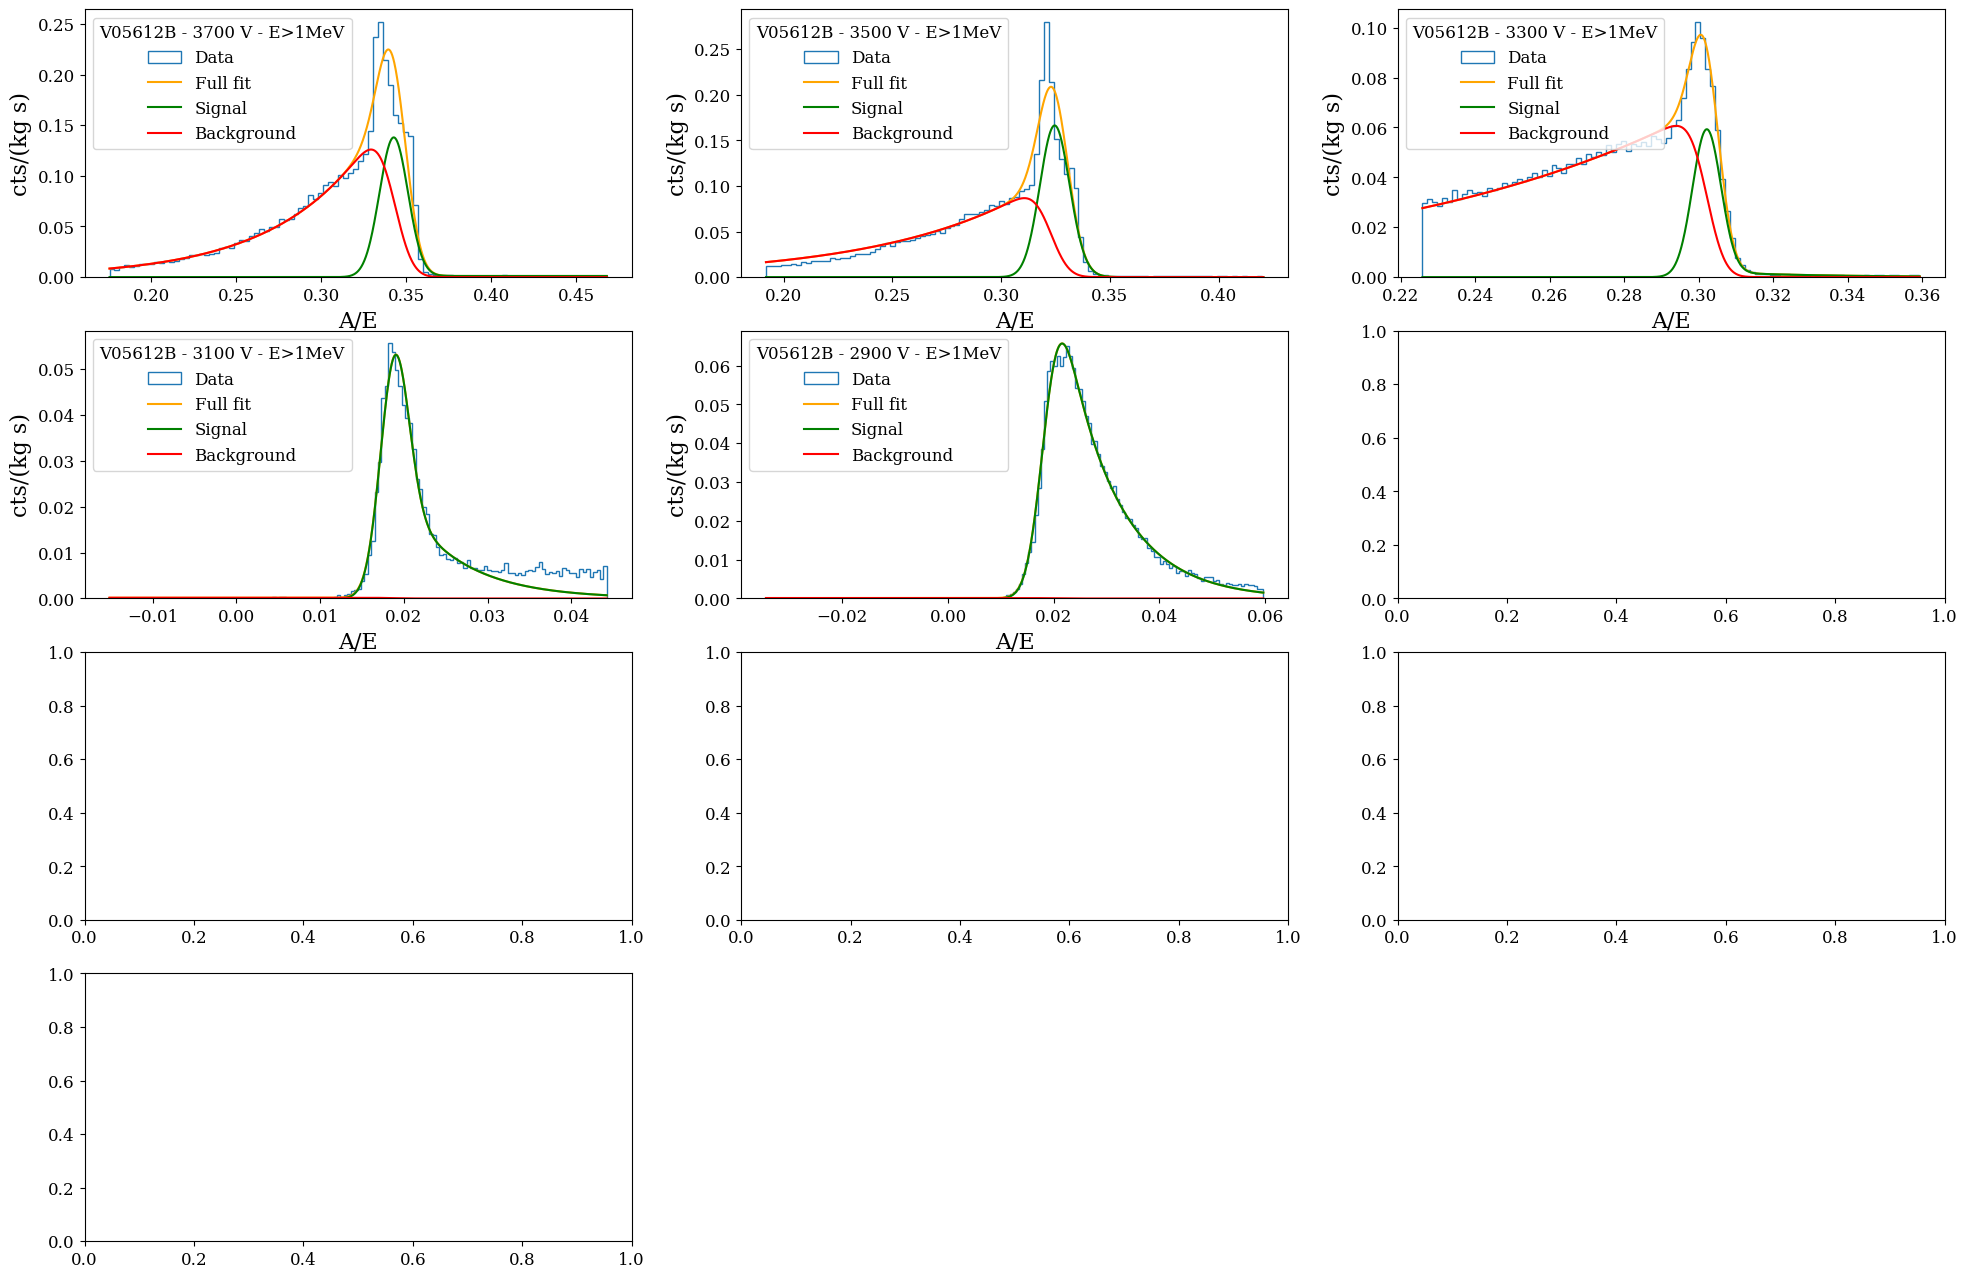

In [189]:
fig, axis = plt.subplots(nrows=4,ncols=3,figsize=(24,16), facecolor='white')
axis[3][1].axis('off')
axis[3][2].axis('off')

nscan = 0
for a_max_scan, energies_scan, exposures_scan, voltages_scan in zip(a_max[n_det],energies[n_det],exposures[n_det], voltages[n_det]):
    #if nscan>1: continue
    print('voltage', voltages_scan) 
    ax = axis.flat[nscan]
    aoe = a_max_scan/energies_scan
    print(np.isnan(a_max_scan).any())
    cut = (energies_scan>1000) & (aoe<1000)
    aoe = aoe[cut]
    par, err, migrad, _ = aoe_cal.unbinned_aoe_fit(aoe, pdf=pdf_fit, display=0)
    mu = par[1] 
    sigma = par[2]
    fmin = mu - 20 * sigma
    fmax = mu + 15 * sigma 
    print(fmin, fmax)
    xs = np.linspace(fmin, fmax, 1000)
    counts, bins, bars = ax.hist(
        aoe[(aoe < fmax) & (aoe > fmin)], bins=100, histtype="step", label="Data",  weights=np.ones_like(aoe[(aoe < fmax) & (aoe > fmin)])/exposures_scan
    )
    dx = np.diff(bins)
    tot = pdf_fit().pdf(xs, *par[:-1],False)
    tot_width=tot*dx[0]/exposures_scan
    sig, bkg = pdf_fit().pdf(xs, *par[:-1], True)

    ax.plot(xs, tot_width, label="Full fit")
    ax.plot(xs, sig *dx[0]/exposures_scan , label="Signal")
    ax.plot(xs, bkg *dx[0]/exposures_scan, label="Background")          
    ax.set_xlabel('A/E')
    ax.set_ylabel('cts/(kg s)')
    ax.legend(loc='upper left',title=f'{detectors[n_det]} - {voltages_scan:.0f} V - E>1MeV')

    #study of S/B
    if (SoB==True):            
        lower_range = mu-3*sigma
        upper_range = mu+3*sigma
        int_bkg = pgf.gauss_tail_integral(np.array([lower_range, upper_range]), mu, sigma, par[4])
        area_bkg = int_bkg[1]-int_bkg[0]
        SoB_max = max(sig)/max(bkg)
        SoB_3sigma = par[0]/(area_bkg*par[3])
        print('S/B max', SoB_max)
        print('S/B 3sigma',SoB_3sigma)
        SoB_max_array.append(SoB_max)
        SoB_3sigma_array.append(SoB_3sigma)
    print('\n')
    nscan+=1

In [157]:
SoB_max_array

[2.577411522362385,
 2.5911034116655376,
 2.8276987823905633,
 4.312662102932353,
 115984.77280554554,
 0.033364859742086424,
 87.54817243066476,
 25.277251302664393,
 14.25391313942466]

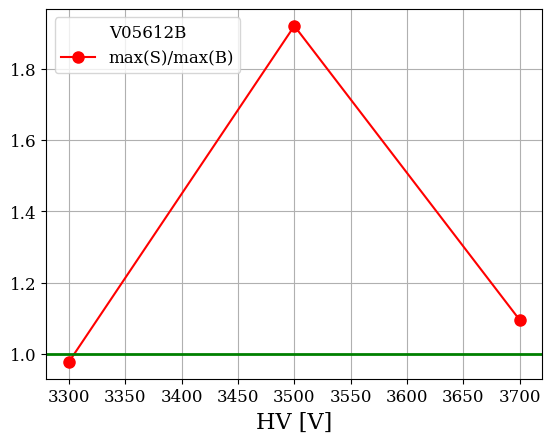

In [191]:
if SoB == True:
    voltages_scan=voltages[n_det]
    fig, axis = plt.subplots() 
    #axis.plot(voltages_scan[:3],SoB_3sigma_array[:3], c='b',marker='o',ms=8,label='S/B at 3sigma')
    axis.plot(voltages_scan[:3],SoB_max_array[:3], c='r',marker='o',ms=8,label='max(S)/max(B)')
    #axis.set_ylim([0, 2])
    axis.set_xlabel('HV [V]')
    axis.legend(title=f'{detectors[n_det]}', loc='upper left')
    axis.grid()
    axis.axhline(1.0,c='g',ls='-',lw=2)
    fig.show()

### Study on the asymmetry of A/E distribution with right/left bands (A/E tails)

voltage 3700.0
cut: >1MeV
half [0.0214756] [0.01132812]
quarter [0.05907787] [0.01572772]
eighth [0.09741683] [0.01908884]
cut: 1-1.4MeV
half [0.01280343] [0.01109599]
quarter [0.02589204] [0.01558874]
eighth [0.09728832] [0.01906594]
cut: 1.7-2MeV
half [0.01706882] [0.01407884]
quarter [0.03343192] [0.01976875]
eighth [0.07154777] [0.02410405]


voltage 3500.0
cut: >1MeV
half [0.01270229] [0.00878258]
quarter [0.05060917] [0.01237572]
eighth [0.09879627] [0.01515286]
cut: 1-1.4MeV
half [0.00374925] [0.00672483]
quarter [0.00582362] [0.01231574]
eighth [0.04151697] [0.01790723]
cut: 1.7-2MeV
half [0.00319779] [0.00431363]
quarter [0.01262387] [0.01349028]
eighth [0.03927633] [0.02359901]


voltage 3300.0
cut: >1MeV
half [0.02692581] [0.0053138]
quarter [0.07471148] [0.00738222]
eighth [0.07471148] [0.00900482]
cut: 1-1.4MeV
half [0.00747038] [0.0056416]
quarter [0.05071472] [0.00791903]
eighth [0.08634282] [0.00971923]
cut: 1.7-2MeV
half [0.0120649] [0.0046827]
quarter [0.0600822] [0.0

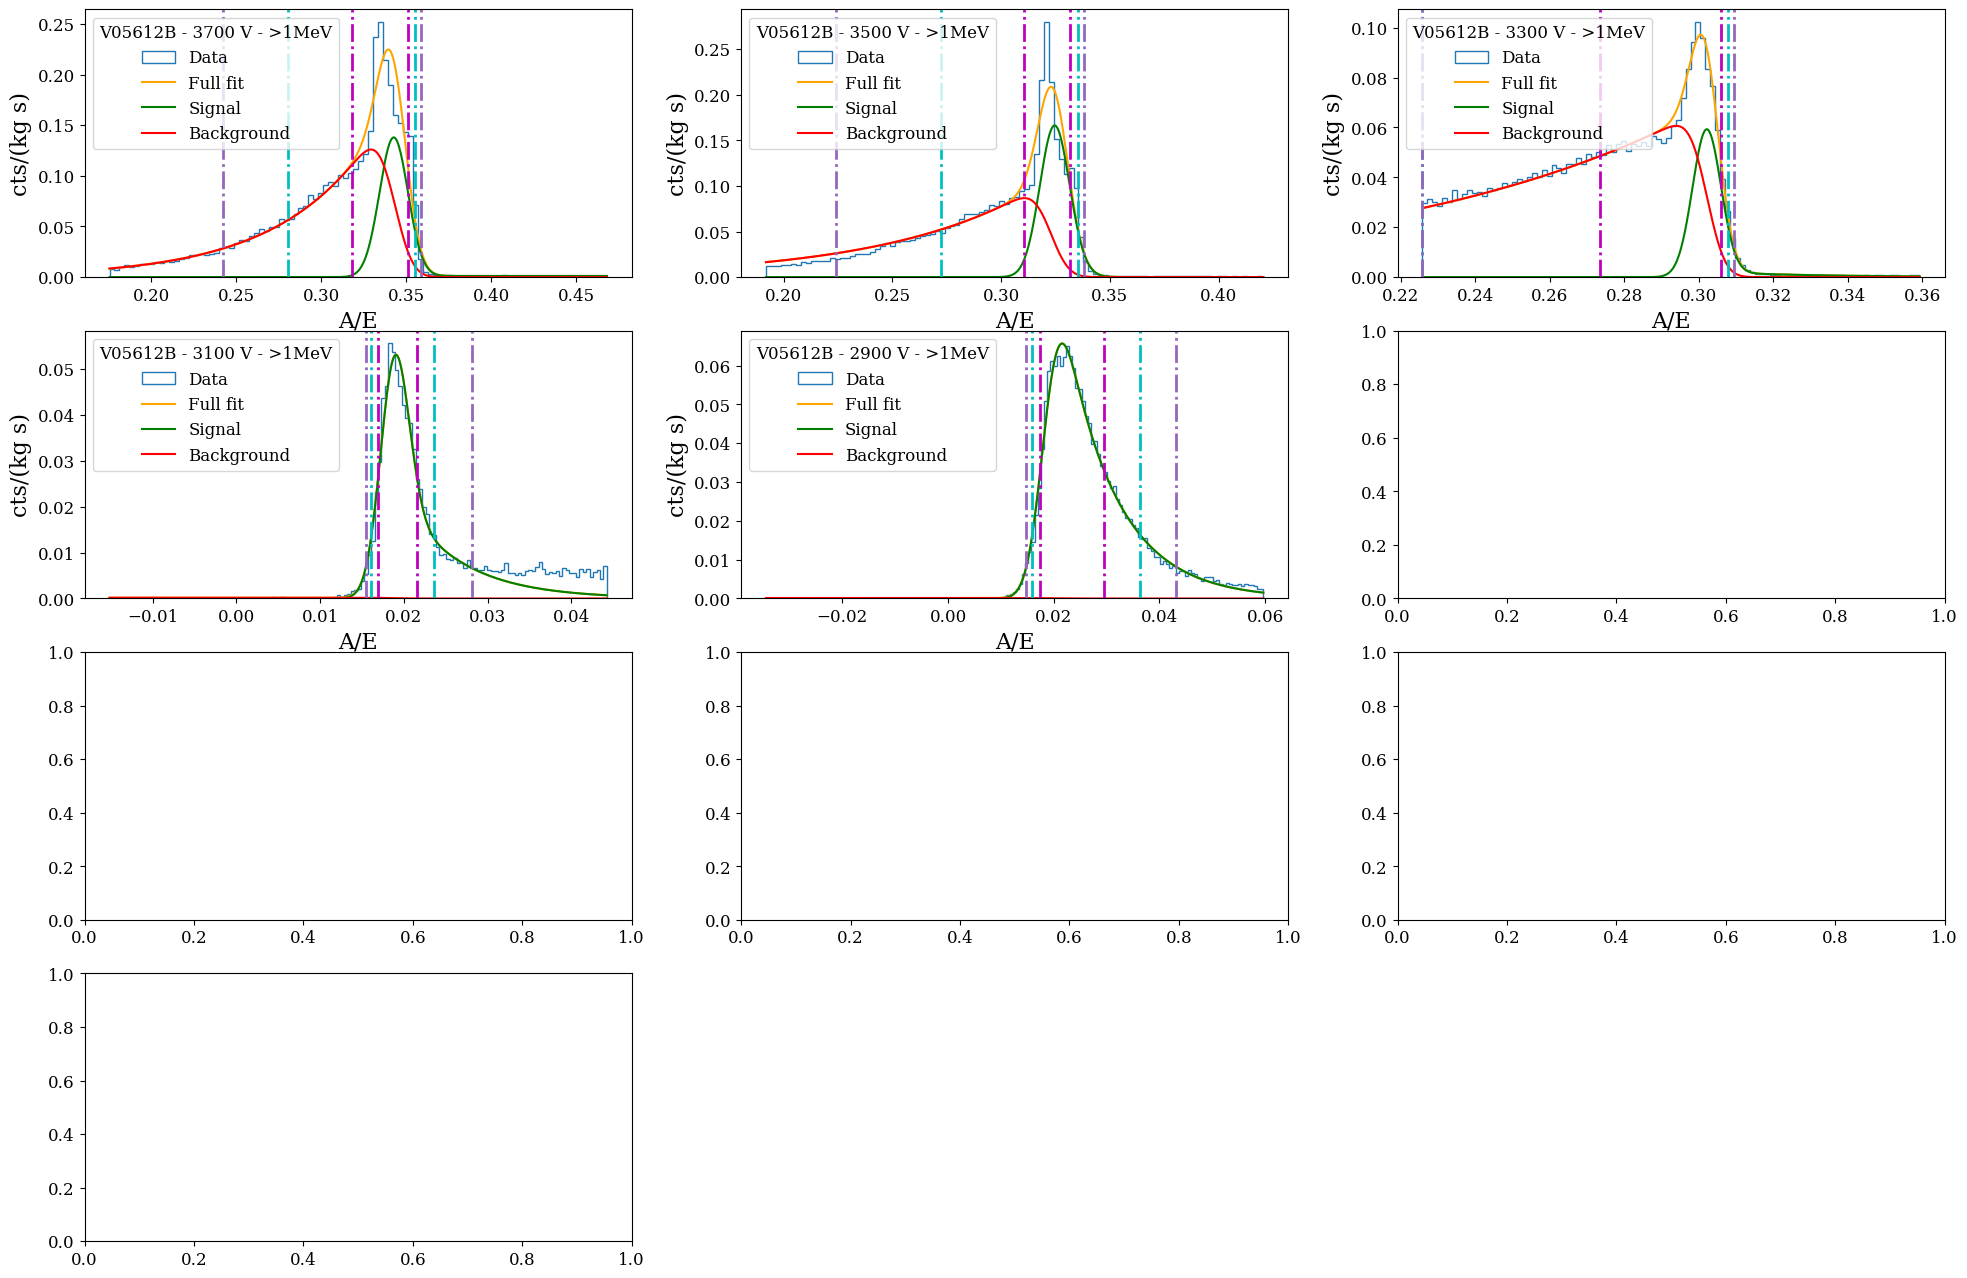

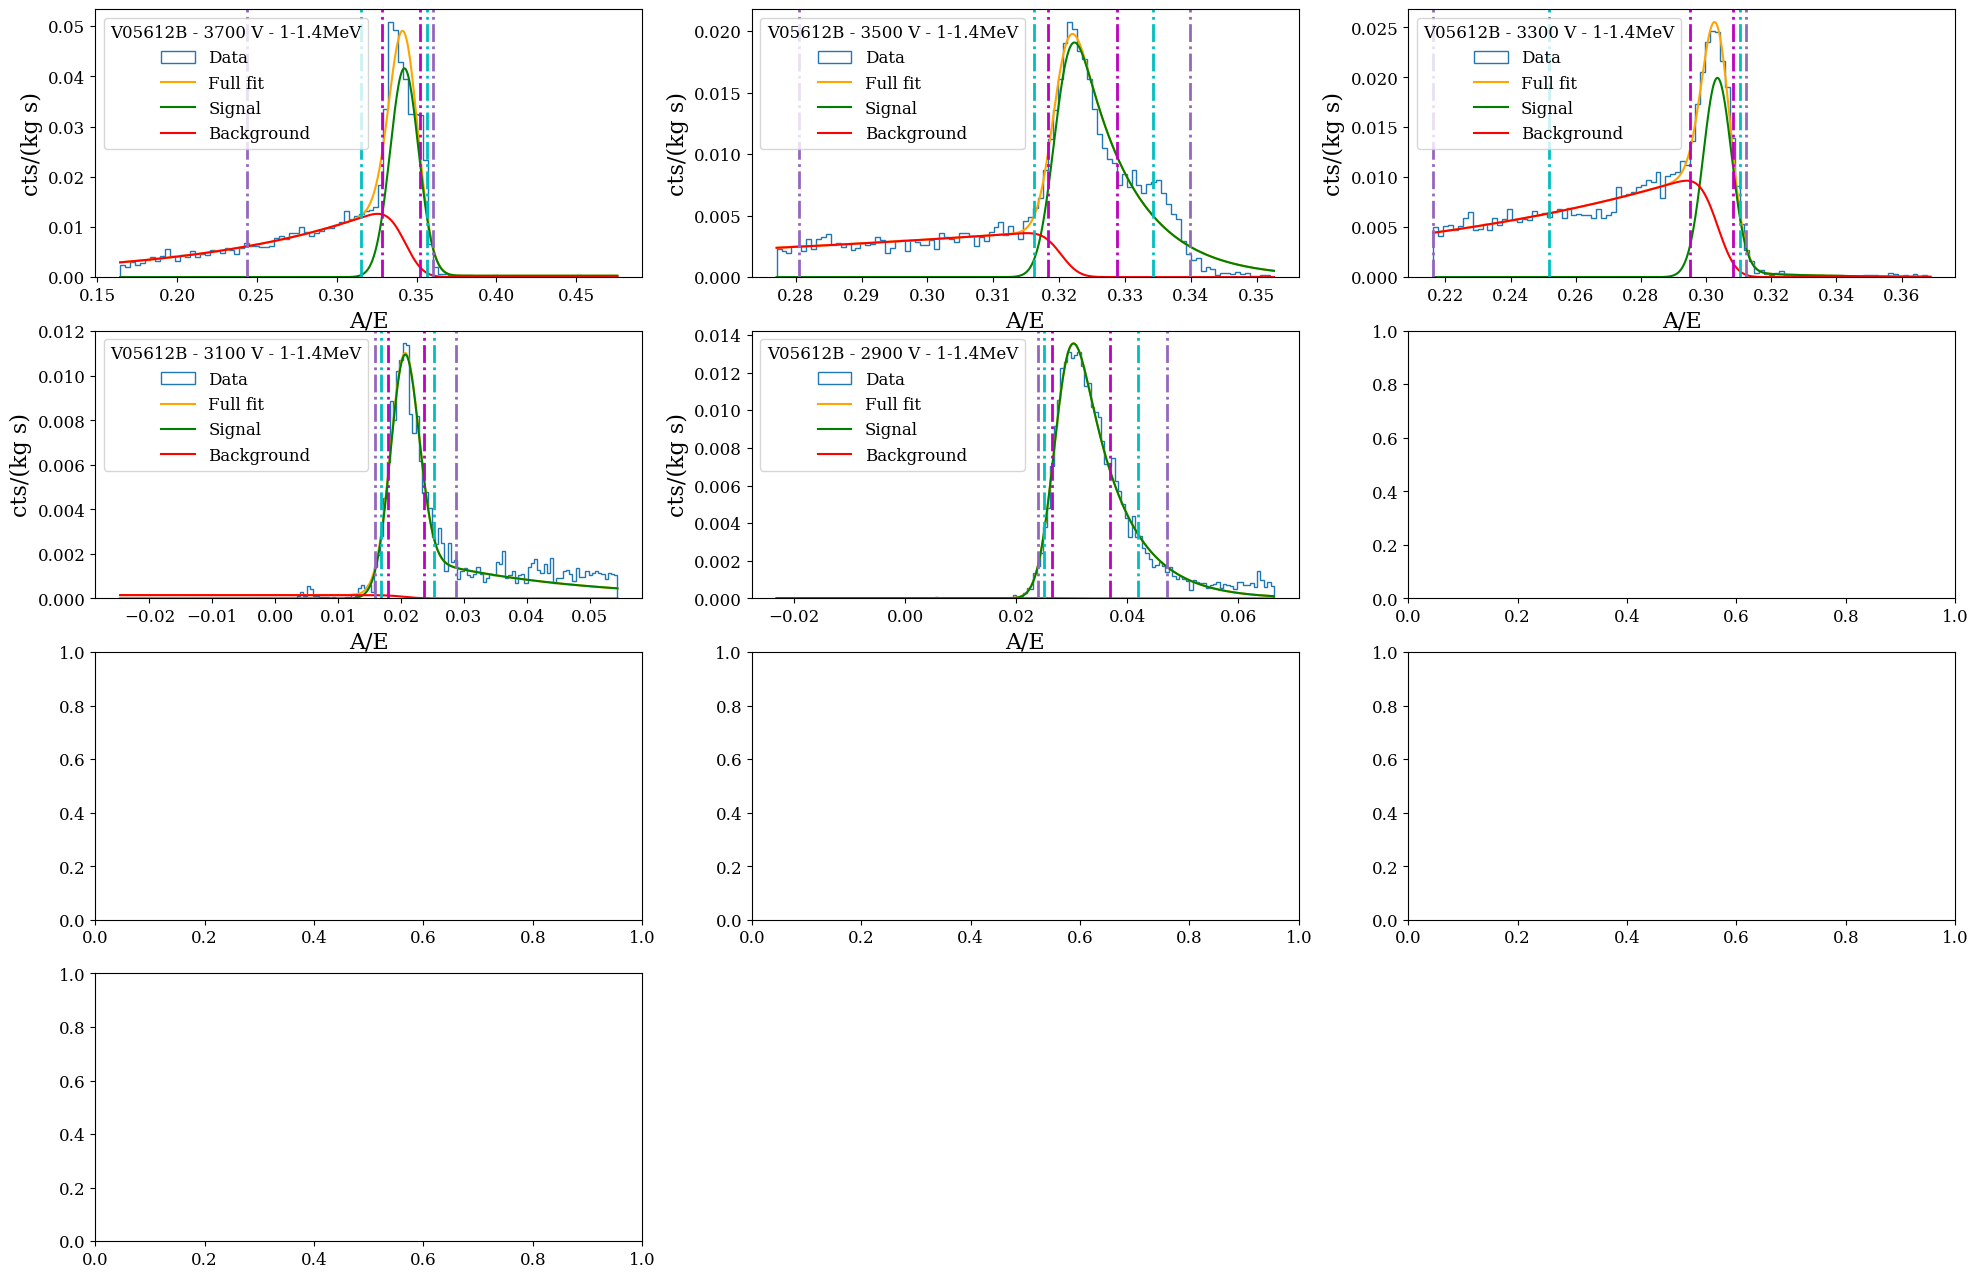

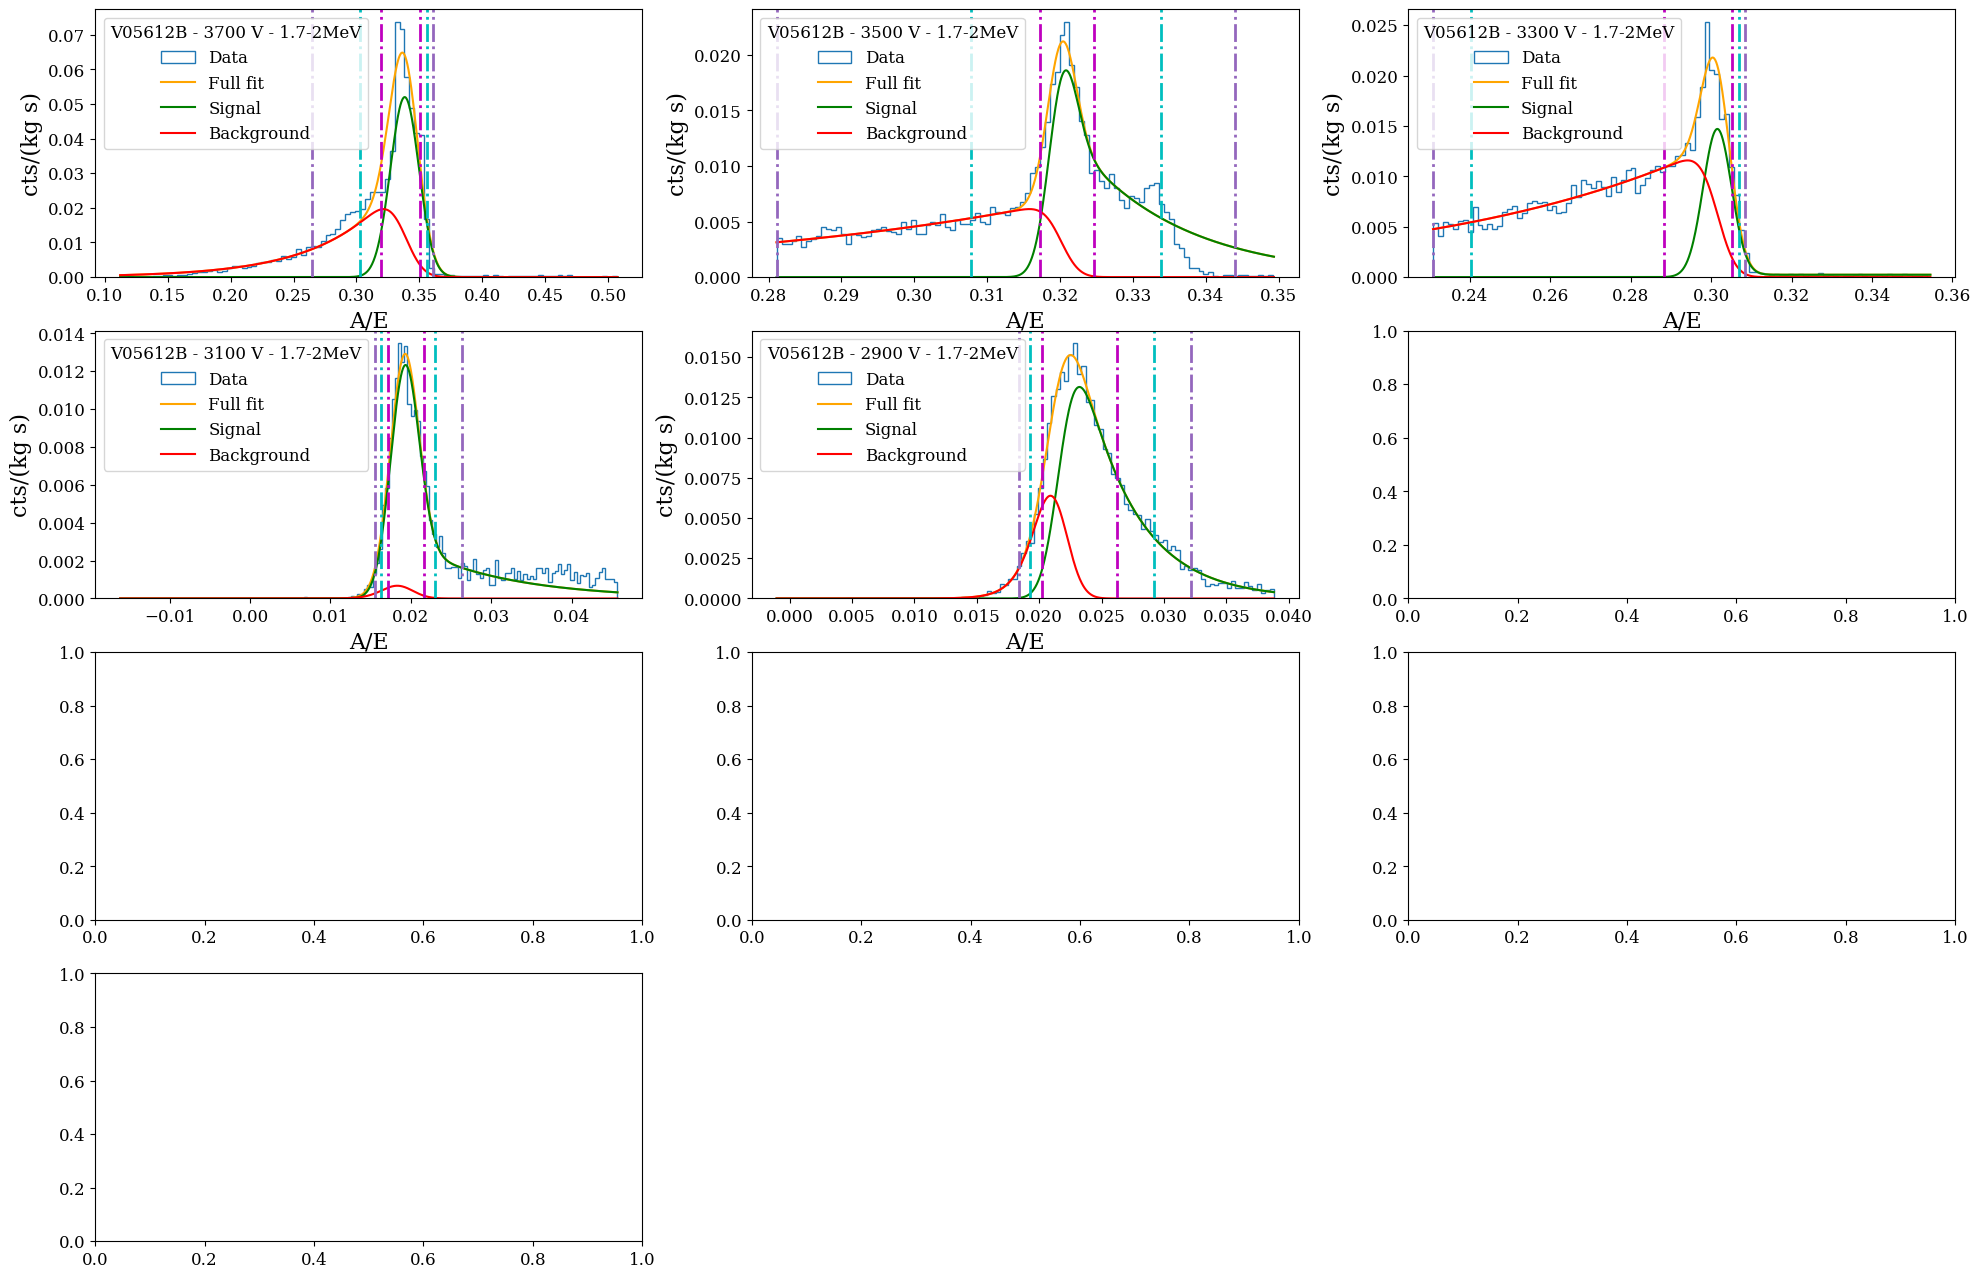

In [192]:
fig1, axis1 = plt.subplots(nrows=4,ncols=3,figsize=(24,16), facecolor='white')
fig2, axis2 = plt.subplots(nrows=4,ncols=3,figsize=(24,16), facecolor='white')
fig3, axis3 = plt.subplots(nrows=4,ncols=3,figsize=(24,16), facecolor='white')
axis1[3][1].axis('off')
axis1[3][2].axis('off')
axis2[3][1].axis('off')
axis2[3][2].axis('off')
axis3[3][1].axis('off')
axis3[3][2].axis('off')
figs = [fig1, fig2, fig3]
axes = [axis1, axis2, axis3]

peak_aoe, fwhm_aoe, fwhm_aoe_var = [[] for i in range(3)], [[] for i in range(3)],  [[] for i in range(3)]
peak_aoe_err, fwhm_aoe_var_err = [[] for i in range(3)],  [[] for i in range(3)]
width_halff, width_quarterr, width_eighthh = [[] for i in range(3)], [[] for i in range(3)], [[] for i in range(3)]
width_half_hist, width_quarter_hist = [[] for i in range(3)], [[] for i in range(3)]


nscan = 0
for a_max_scan, energies_scan, exposures_scan, voltages_scan in zip(a_max[n_det],energies[n_det],exposures[n_det], voltages[n_det]):
    print('voltage', voltages_scan)
    cuts_titles = ['>1MeV','1-1.4MeV', '1.7-2MeV']
    cuts = [(energies_scan>1000), ( (energies_scan>1000) & (energies_scan<1400) ),( (energies_scan>1700) & (energies_scan<2100))]
    for idx, cut in enumerate(cuts):
        print('cut:', cuts_titles[idx])
        ax1 = axis1.flat[nscan]
        ax2 = axis2.flat[nscan]
        ax3 = axis3.flat[nscan]
        axs = [ax1, ax2, ax3]
        ax = axs[idx]
        aoe = a_max_scan/energies_scan
        aoe = aoe[(cut) & (aoe<1000)]
        par, err, migrad, _ = aoe_cal.unbinned_aoe_fit(aoe, pdf=pdf_fit, display=0)
        mu = par[1]
        sigma = par[2]
        mu_err = err[1]
        sigma_err = err[2]
        peak_aoe[idx].append(mu)
        peak_aoe_err[idx].append(mu_err)
        fwhm_aoe[idx].append(sigma*2.355)
        fwhm_aoe_var[idx].append(sigma*2.355/mu)
        fwhm_aoe_var_err[idx].append(math.sqrt( pow(sigma/mu,2)*( pow(sigma_err/sigma,2) +pow(mu_err/mu,2) ))*2.355)          
        fmin = mu - 20 * sigma
        fmax = mu + 15 * sigma
        xs = np.linspace(fmin, fmax, 1000)
        counts, bins, bars = ax.hist(
            aoe[(aoe < fmax) & (aoe > fmin)], bins=100, histtype="step", label="Data",  weights=np.ones_like(aoe[(aoe < fmax) & (aoe > fmin)])/exposures_scan
        )
        dx = np.diff(bins)
        tot = pdf_fit().pdf(xs, *par[:-1],False)
        tot_width=tot*dx[0]/exposures_scan
        sig, bkg = pdf_fit().pdf(xs, *par[:-1], True)
        
        ax.plot(xs, tot_width, label="Full fit")
        ax.plot(xs, sig *dx[0]/exposures_scan , label="Signal")
        ax.plot(xs, bkg *dx[0]/exposures_scan, label="Background")          
        ax.set_xlabel('A/E')
        ax.set_ylabel('cts/(kg s)')
        ax.legend(loc='upper left',title=f'{detectors[n_det]} - {voltages_scan:.0f} V - {cuts_titles[idx]}')

        max_y=max(tot_width)
        x_max=xs[tot_width==max_y]
        x_interp_half_left = np.interp(max_y/2, tot_width[xs<x_max], xs[xs<x_max])
        x_interp_quarter_left = np.interp(max_y/4, tot_width[xs<x_max], xs[xs<x_max])
        x_interp_eighth_left = np.interp(max_y/8, tot_width[xs<x_max], xs[xs<x_max])
        tot_reverse=tot_width[xs>x_max]
        tot_reverse=tot_reverse[::-1]
        xs_reverse=xs[xs>x_max]
        xs_reverse=xs_reverse[::-1]
        x_interp_half_right = np.interp(max_y/2, tot_reverse, xs_reverse)
        x_interp_quarter_right = np.interp(max_y/4, tot_reverse, xs_reverse)
        x_interp_eighth_right = np.interp(max_y/8, tot_reverse, xs_reverse)
        width_half_right=(x_interp_half_right-x_max)
        width_half_left=(x_max-x_interp_half_left)
        width_quarter_right=(x_interp_quarter_right-x_max)
        width_quarter_left=(x_max-x_interp_quarter_left)
        width_eighth_right=(x_interp_eighth_right-x_max)
        width_eighth_left=(x_max-x_interp_eighth_left)
        width_half_diff=(width_half_left-width_half_right)/(x_max*(width_half_right+width_half_left))
        width_quarter_diff=(width_quarter_left-width_quarter_right)/(x_max*(width_quarter_right+width_quarter_left))
        width_eighth_diff=(width_eighth_left-width_eighth_right)/(x_max*(width_eighth_right+width_eighth_left))
        width_halff[idx].append(width_half_diff[0])
        width_quarterr[idx].append(width_quarter_diff[0])
        width_eighthh[idx].append(width_eighth_diff[0])

        ax.axvline(x_interp_half_left,c='m',ls='-.',lw=2)
        ax.axvline(x_interp_half_right,c='m',ls='-.',lw=2)
        ax.axvline(x_interp_quarter_left,c='c',ls='-.',lw=2)
        ax.axvline(x_interp_quarter_right,c='c',ls='-.',lw=2)
        ax.axvline(x_interp_eighth_left,c='tab:purple',ls='-.',lw=2)
        ax.axvline(x_interp_eighth_right,c='tab:purple',ls='-.',lw=2)

        print("half", width_half_left, width_half_right)
        print("quarter", width_quarter_left, width_quarter_right)
        print("eighth", width_eighth_left, width_eighth_right)
    print('\n')
    nscan+=1
    
if save_fig == True:
    savefig(fig1, detectors[n_det], "AoE_spectrum_E>1MeV")
    savefig(fig2, detectors[n_det], "AoE_spectrum_1MeV<E<1.4MeV")
    savefig(fig3, detectors[n_det], "AoE_spectrum_1.7MeV<E<2.1MeV")

In [193]:
#take the values from the old HV scan

with open(f'old_scan/{detectors[n_det]}.json', "r") as outfile: 
    scan_old = json.load(outfile)

voltages_old=list(map(float, scan_old[detectors[n_det]].keys()))


voltages_tot=list(voltages[0]) + voltages_old

peak_aoe_tot = [[],[],[]]
peak_aoe_err_tot = [[],[],[]]

fwhm_aoe_var_tot = [[],[],[]]
fwhm_aoe_var_err_tot = [[],[],[]]

width_halff_tot = [[],[],[]]
width_quarterr_tot = [[],[],[]]
width_eighthh_tot = [[],[],[]]

for i in range(len(peak_aoe)):
    peak_aoe_new = peak_aoe[i]
    peak_aoe_err_new = peak_aoe_err[i]
    fwhm_aoe_var_new = fwhm_aoe_var[i]
    fwhm_aoe_var_err_new = fwhm_aoe_var_err[i]
    width_halff_new = width_halff[i]
    width_quarterr_new = width_quarterr[i]
    width_eighthh_new = width_eighthh[i]
    
    peak_aoe_old=[]
    peak_aoe_err_old=[]
    fwhm_aoe_var_old=[]
    fwhm_aoe_var_err_old=[]
    width_halff_old=[]
    width_quarterr_old=[]
    width_eighthh_old=[]
    for v in scan_old[detectors[n_det]].keys():
        peak_aoe_old_single = list(scan_old[detectors[n_det]][v][cuts_titles[i]].values())[0]
        peak_aoe_old.append(peak_aoe_old_single)
        peak_aoe_err_old_single = list(scan_old[detectors[n_det]][v][cuts_titles[i]].values())[1]
        peak_aoe_err_old.append(peak_aoe_err_old_single)
        fwhm_aoe_var_old_single = list(scan_old[detectors[n_det]][v][cuts_titles[i]].values())[2]
        fwhm_aoe_var_old.append(fwhm_aoe_var_old_single)
        fwhm_aoe_var_err_old_single = list(scan_old[detectors[n_det]][v][cuts_titles[i]].values())[3]
        fwhm_aoe_var_err_old.append(fwhm_aoe_var_err_old_single)
        width_halff_old_single = list(scan_old[detectors[n_det]][v][cuts_titles[i]].values())[4]
        width_halff_old.append(width_halff_old_single)
        width_quarterr_old_single = list(scan_old[detectors[n_det]][v][cuts_titles[i]].values())[5]
        width_quarterr_old.append(width_halff_old_single)
        width_eighthh_old_single = list(scan_old[detectors[n_det]][v][cuts_titles[i]].values())[6]
        width_eighthh_old.append(width_halff_old_single)

    peak_aoe_tot[i] = peak_aoe_new + peak_aoe_old
    peak_aoe_err_tot[i] = peak_aoe_err_new + peak_aoe_err_old
    fwhm_aoe_var_tot[i] = fwhm_aoe_var_new + fwhm_aoe_var_old
    fwhm_aoe_var_err_tot[i] = fwhm_aoe_var_err_new + fwhm_aoe_var_err_old
    width_halff_tot[i] = width_halff_new + width_halff_old
    width_quarterr_tot[i] = width_quarterr_new + width_quarterr_old
    width_eighthh_tot[i] = width_eighthh_new + width_eighthh_old


peak_aoe = peak_aoe_tot
peak_aoe_err = peak_aoe_err_tot
fwhm_aoe_var = fwhm_aoe_var_tot
fwhm_aoe_var_err = fwhm_aoe_var_err_tot
width_halff = width_halff_tot
width_quarterr = width_quarterr_tot
width_eighthh = width_eighthh_tot


In [194]:
print(len(voltages_tot))
#print(voltages)
voltages[0]=voltages_tot
print(voltages[0])
#voltages[0][4] = 2800.0

20
[3700.0, 3500.0, 3300.0, 3100.0, 2900.0, 2700.0, 2500.0, 2300.0, 2100.0, 1900.0, 4700.0, 4600.0, 4500.0, 4400.0, 4300.0, 4200.0, 4000.0, 3800.0, 3600.0, 3400.0]


In [197]:
len(voltages[0][10:])
len(peak_aoe[0][10:])

5

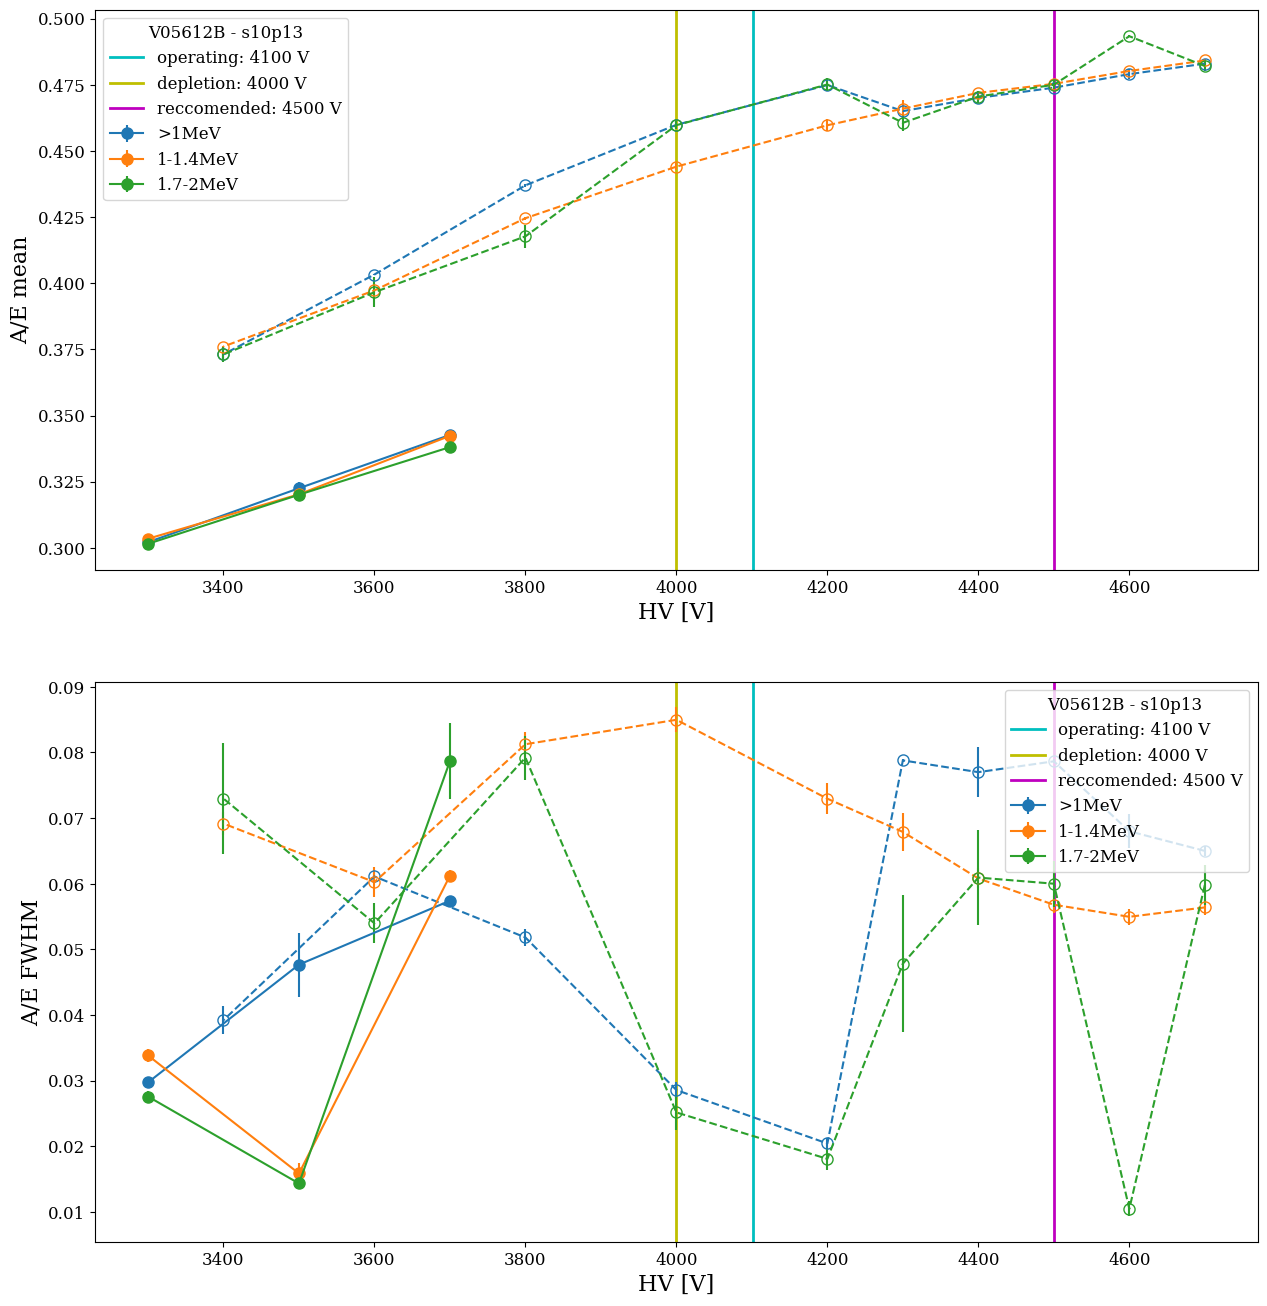

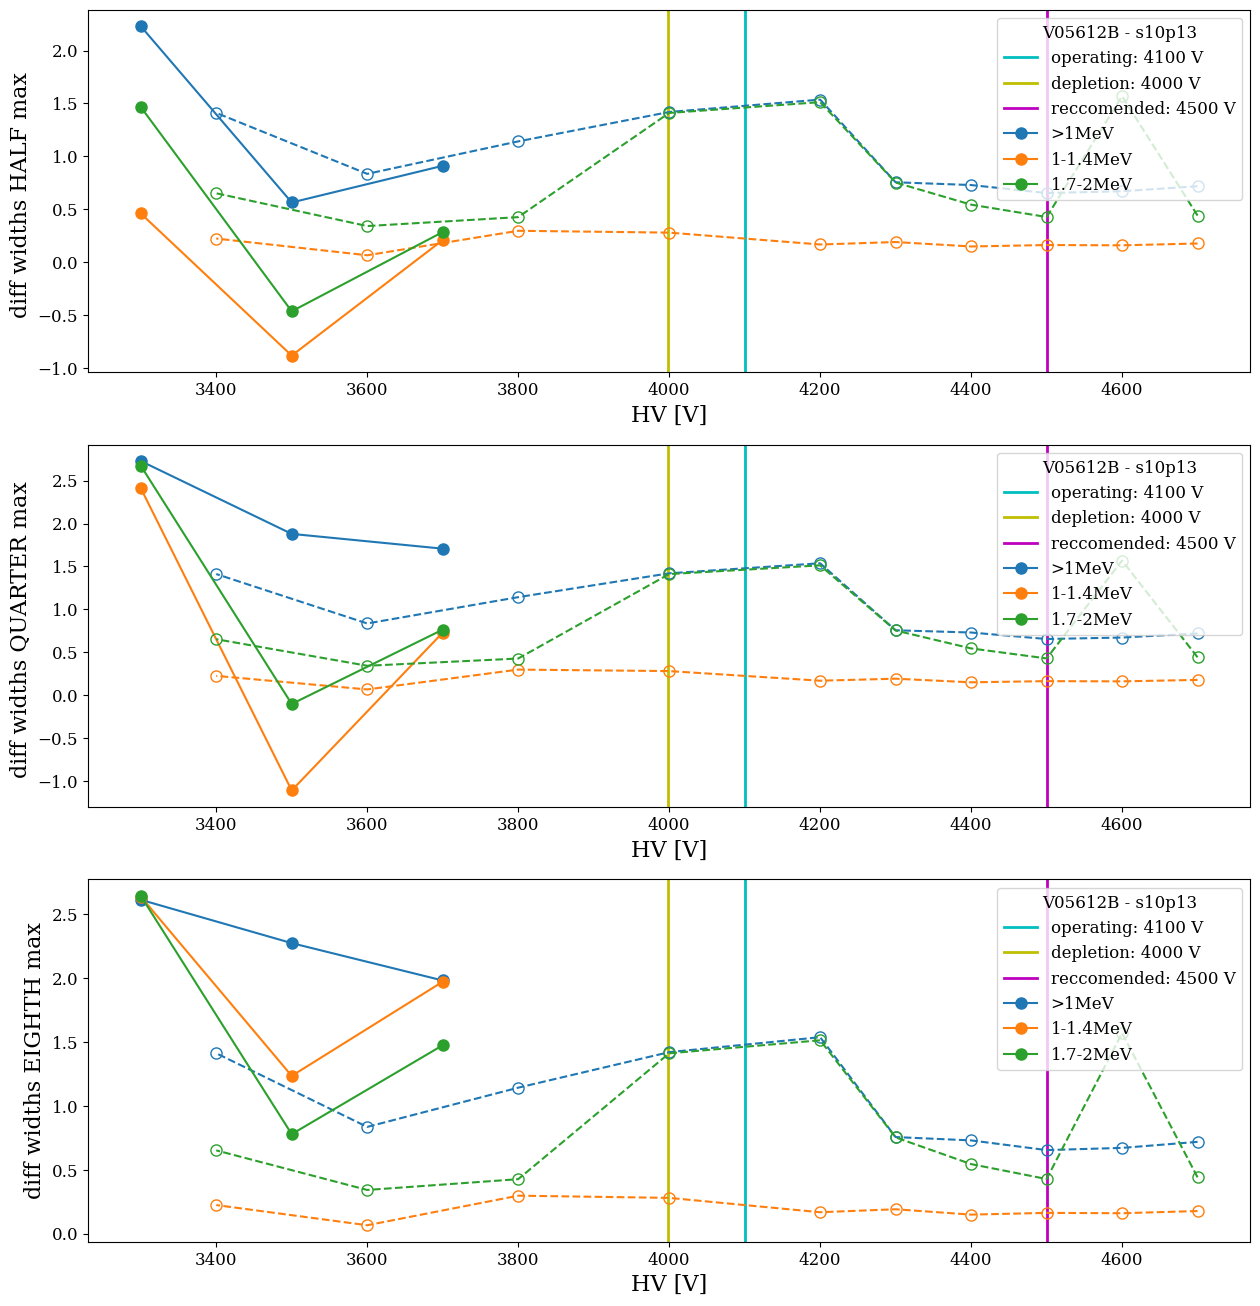

In [200]:
fig_summary, axis_summary = plt.subplots(nrows=2, figsize=(15,16), facecolor='white') 
fig_width, axis_width = plt.subplots(nrows=3, figsize=(15,16), facecolor='white')    

col = ['tab:blue','tab:orange','tab:green']
operating = float(operating_all[n_volt])
depletion = float(depletion_all[n_volt])
reccomended = float(reccomended_all[n_volt])

for i, cut_title in enumerate(cuts_titles):
    voltages_array, mu_pos, sigma_pos = np.array(voltages[0][:nint]), np.array(peak_aoe[i][:nint]), np.array(fwhm_aoe_var[i][:nint])
    mu_pos_err, sigma_pos_err = np.array(peak_aoe_err[i][:nint]), np.array(fwhm_aoe_var_err[i][:nint])
    width_half,  width_quarter,  width_eighth= np.array(width_halff[i][:nint]) ,np.array(width_quarterr[i][:nint]), np.array(width_eighthh[i][:nint])
    if i ==0:
        axis_summary[0].axvline(operating+1,c='c',ls='-',lw=2,label=f'operating: {operating:.0f} V')
        axis_summary[1].axvline(operating+1,c='c',ls='-',lw=2,label=f'operating: {operating:.0f} V')
        axis_width[0].axvline(operating+1,c='c',ls='-',lw=2,label=f'operating: {operating:.0f} V')
        axis_width[1].axvline(operating+1,c='c',ls='-',lw=2,label=f'operating: {operating:.0f} V')
        axis_width[2].axvline(operating+1,c='c',ls='-',lw=2,label=f'operating: {operating:.0f} V')
        if manufacturer_hv:
            axis_summary[0].axvline(depletion-1,c='y',ls='-',lw=2,label=f'depletion: {depletion:.0f} V')
            axis_summary[0].axvline(reccomended,c='m',ls='-',lw=2,label=f'reccomended: {reccomended:.0f} V')
            axis_summary[1].axvline(depletion-1,c='y',ls='-',lw=2,label=f'depletion: {depletion:.0f} V')
            axis_summary[1].axvline(reccomended,c='m',ls='-',lw=2,label=f'reccomended: {reccomended:.0f} V')
            axis_width[0].axvline(depletion-1,c='y',ls='-',lw=2,label=f'depletion: {depletion:.0f} V')
            axis_width[0].axvline(reccomended,c='m',ls='-',lw=2,label=f'reccomended: {reccomended:.0f} V')
            axis_width[1].axvline(depletion-1,c='y',ls='-',lw=2,label=f'depletion: {depletion:.0f} V')
            axis_width[1].axvline(reccomended,c='m',ls='-',lw=2,label=f'reccomended: {reccomended:.0f} V')
            axis_width[2].axvline(depletion-1,c='y',ls='-',lw=2,label=f'depletion: {depletion:.0f} V')
            axis_width[2].axvline(reccomended,c='m',ls='-',lw=2,label=f'reccomended: {reccomended:.0f} V')
    
    axis_summary[0].errorbar(voltages_array[:3],mu_pos[:3],mu_pos_err[:3],c=col[i] ,marker='o',ms=8,label=f'{cut_title}')
    axis_summary[0].errorbar(voltages_array[10:],mu_pos[5:],mu_pos_err[5:],c=col[i] ,marker='o',ms=8, ls='--',markerfacecolor='none')
    axis_summary[0].set_xlabel('HV [V]')
    axis_summary[0].set_ylabel('A/E mean')
    axis_summary[0].legend(title=f'{detectors[n_det]} - s{string:02}p{position:02}', loc='upper left')

    axis_summary[1].errorbar(voltages_array[:3],sigma_pos[:3],sigma_pos_err[:3],c=col[i], marker='o',ms=8,label=f'{cut_title}')
    axis_summary[1].errorbar(voltages_array[10:],sigma_pos[5:],sigma_pos_err[5:],c=col[i],marker='o',ms=8, ls='--', markerfacecolor='none')
    axis_summary[1].set_xlabel('HV [V]')
    axis_summary[1].set_ylabel('A/E FWHM')
    axis_summary[1].legend(title=f'{detectors[n_det]} - s{string:02}p{position:02} ',loc='upper right')


    axis_width[0].plot(voltages_array[:3],width_half[:3], c=col[i] ,marker='o',ms=8,label=f'{cut_title}')
    axis_width[0].plot(voltages_array[10:],width_half[5:], c=col[i] ,marker='o',ms=8, ls='--', markerfacecolor='none')
    axis_width[0].set_xlabel('HV [V]')
    axis_width[0].set_ylabel('diff widths HALF max ')
    axis_width[0].legend(title=f'{detectors[n_det]} - s{string:02}p{position:02}', loc='upper right')

    axis_width[1].plot(voltages_array[:3],width_quarter[:3],c=col[i] ,marker='o',ms=8,label=f'{cut_title}')
    axis_width[1].plot(voltages_array[10:],width_quarter[5:],c=col[i] ,marker='o',ms=8, ls='--', markerfacecolor='none')
    axis_width[1].set_xlabel('HV [V]')
    axis_width[1].set_ylabel('diff widths QUARTER max ')
    axis_width[1].legend(title=f'{detectors[n_det]} - s{string:02}p{position:02}', loc='upper right')
    
    axis_width[2].plot(voltages_array[:3],width_eighth[:3],c=col[i] ,marker='o',ms=8,label=f'{cut_title}')
    axis_width[2].plot(voltages_array[10:],width_eighth[5:],c=col[i] ,marker='o',ms=8, ls='--', markerfacecolor='none')
    axis_width[2].set_xlabel('HV [V]')
    axis_width[2].set_ylabel('diff widths EIGHTH max')
    axis_width[2].legend(title=f'{detectors[n_det]} - s{string:02}p{position:02}', loc='upper right') 

if save_fig == True:
    savefig(fig_summary, detectors[n_det], "AoE_mean_FWHM")
    savefig(fig_width, detectors[n_det], "AoE_asymmetry")